In [2]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.8

import numpy as np
import jax.numpy as jnp
import jax.scipy as jsc
import matplotlib.pyplot as plt
from jax import random
from scipy.linalg import circulant
from jax import grad, jit, vmap, value_and_grad
import optax
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

import os
import sys

file = open("../../../../meta.txt")
home = file.read().replace("\n", "/")
file.close()
    
p = os.path.abspath(home+'mypylib')
if p not in sys.path:
    sys.path.append(p)

import chunGP as gp

def getStepDataSimple(angles,thres=0):
    X=np.block([[np.cos(angles)],[np.sin(angles)]]).T
    Y=(np.sin(angles)>=thres)[:,None]*2.0 - 1
    return X,Y

def loadData(dataName,N,P,seed=0,zeromean=False):
    np.random.seed(seed)

    All=True
    if dataName=='MNIST':
        X,_,t_train,_,Y,_,_,_,_,_=\
            gp.getMNIST(N_train=N,N_test=100,normalize=True,seed=seed,All=All)
    if dataName=='Fashion':
        X,_,t_train,_,Y,_,_,_,_,_=\
            gp.getFashion(N_train=N,N_test=100,normalize=True,seed=seed,All=All,home=home)
    if dataName=='CIFAR':
        grayscale=False
        X,_,t_train,_,Y,_,_,_,_,_=\
            gp.getCIFAR(N_train=N,N_test=100,normalize=True,seed=seed,grayscale=grayscale,All=All,home=home)
    if dataName=='CIFARG':
        grayscale=True
        X,_,t_train,_,Y,_,_,_,_,_=\
            gp.getCIFAR(N_train=N,N_test=100,normalize=True,seed=seed,grayscale=grayscale,All=All,home=home)
    if dataName=='Circulant':
        angles=np.linspace(0,2*np.pi,N)
        X,Y=getStepDataSimple(angles,thres=0)
    
    X=X/np.sqrt(np.sum(np.square(X),axis=1))[:,None]

    train_idx=np.random.choice(np.arange(N),P,replace=False)

    train_ID=np.ones(N)==0
    train_ID[train_idx]=True
    test_ID=np.invert(train_ID)

    x_train=X[train_ID,:]
    x_test=X[test_ID,:]

    if zeromean:
        Y=Y-np.mean(Y)
        
    y_train=Y[train_ID,:]
    y_test=Y[test_ID,:]
    
    return X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID

def accuracy(y_pred,y):
    return jnp.mean(y_pred == y)
def getNN(yr_test,y_class):
    pdist=pairwise_distances(yr_test, y_class, metric='euclidean')
    tp_test=jnp.argmin(pdist,axis=1)
    return y_class[tp_test,:],tp_test
def getMax(yr_test):
    tp_test=jnp.argmax(yr_test,axis=1)
    return tp_test


env: XLA_PYTHON_CLIENT_MEM_FRACTION=.8


In [3]:
from scipy.optimize import fsolve
import scipy as sp

def getkfunc(s0,eta,P):
    def func_root(ka):
        return s0 + np.sum((ka*eta)/(ka+P*eta)) - ka
    return func_root

def getgam(eta,P,ka):
    return np.sum(P*np.square(eta)/np.square(ka+P*eta))
###

def kappa_fn(kappa, *args):
    (p, lamb, spectrum, degens) = args
    return kappa - lamb - kappa * np.sum(spectrum*degens/(p*spectrum + kappa))

def kappa_fn_derivative(kappa, *args):
    (p, lamb, spectrum, degens) = args
    return 1 - np.sum(spectrum*degens/(p*spectrum + kappa)) + kappa*np.sum(spectrum*degens/(p*spectrum + kappa)**2)

def solve_kappa(p, lamb, spectrum, degens = []):
    if len(degens) == 0:
        degens = np.ones(len(spectrum))
    
    args = (p, lamb, spectrum, degens)
    return sp.optimize.root_scalar(kappa_fn, x0 = p*np.amax(spectrum), args = args, 
                                   fprime = kappa_fn_derivative, method = 'newton').root

def gamma_fn(p, kappa, spectrum, degens = []):
    if len(degens) == 0:
        degens = np.ones(len(spectrum))
        
    return p * degens * spectrum**2 / (kappa + spectrum*p)**2
###

def runTrial(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,m=0,dotheory=False,s0=0,sep=False,x_test=0,y_test=0,prepend='',append=''):
    resolution=100000000#100000000
    trapz_n=10000
    chunk_size=100000

    Ls=jnp.arange(2,20)
    #pas=[0.4999,0.2,0.1]
    pas=jnp.linspace(0.4999,0.01,20)
    taus=gp.getTau(jnp.array(pas))

    alpha=P/N

    errAf=np.zeros((jnp.shape(taus)[0],jnp.shape(Ls)[0]))
    errTf=np.copy(errAf)
    accAf=np.copy(errAf)
    Kaps=np.copy(errAf)
    Gams=np.copy(errAf)
    etas=np.zeros((jnp.shape(taus)[0],jnp.shape(Ls)[0],N))
    VT=np.zeros((jnp.shape(taus)[0],jnp.shape(Ls)[0],N,np.shape(Y)[1]))
    ERO=np.copy(etas)
    for j, tau in enumerate(taus):
        sigma=np.squeeze(gp.getosig(tau))
        converter=gp.getConverter_chunk_save_load(tau=tau,resolution=resolution,trapz_n=trapz_n,chunk_size=chunk_size,silence=False,home=home)

        if dotheory:
            load_names_te=gp.getSCK_fast_and_save(X,X,converter,mh0=0,mw0=0,mh=0,mw=m,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='test')
        elif sep:
            load_names_tr=gp.getSCK_fast_and_save(x_train,x_train,converter,mh0=0,mw0=0,mh=0,mw=m,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='train')
            load_names_te=gp.getSCK_fast_and_save(x_train,x_test,converter,mh0=0,mw0=0,mh=0,mw=m,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='test')            
        else:
            load_names_tr=gp.getSCK_fast_and_save(x_train,x_train,converter,mh0=0,mw0=0,mh=0,mw=m,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='train')
            load_names_te=gp.getSCK_fast_and_save(x_train,X,converter,mh0=0,mw0=0,mh=0,mw=m,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='test')

        for g, L in enumerate(Ls):
        #try:
            if dotheory:
                K=np.load(load_names_te[g])
                A=K[train_ID,:][:,train_ID]
                C=K[train_ID,:]                
            else:
                K=0
                A=np.load(load_names_tr[g])
                C=np.load(load_names_te[g])


            #yr_test=gp.train_multi(A,A*0.0,C,C*0.0,y_train,corr=False,s0=s0)
            yr_test=gp.train_single_fast(A,C,y_train,s0=s0)
            
            if sep:
                errAf[j,g]=jnp.mean(jnp.square(yr_test-y_test))
                accAf[j,g]=accuracy(getMax(yr_test),getMax(y_test))
            else:
                errAf[j,g]=jnp.mean(jnp.square(yr_test-Y))
                accAf[j,g]=accuracy(getMax(yr_test),getMax(Y))
            print('err:{:.2e}, sigma:{:.2f}, pa:{:.2e}, m:{}, L:{}, '.format(errAf[j,g],sigma,gp.getPa(tau),m,L))

            if dotheory:
                #Phi_d,eta,_=jnp.linalg.svd(K)
                #M=np.sum(eta>0)
                M=N
                eta, Phi_d = jnp.linalg.eigh(K/N)
                inds = jnp.argsort(eta)[::-1]
                eta = jnp.abs(eta[inds] * (eta[inds] > 0))
                #print(eta)
                #Phi_d = Phi_d*jnp.sqrt(N)
                Phi_d = Phi_d[:,inds]#*jnp.sqrt(N)
                
                vteach=jnp.squeeze(jnp.matmul(Phi_d.T,Y))/np.sqrt(N)
                weight_sum=jnp.mean(jnp.square(vteach),axis=1)

                etas[j,g,:]=np.copy(eta)
                
                ka=solve_kappa(P, s0, eta)
                gam=jnp.sum(gamma_fn(P, ka, eta))#getgam(eta,P,ka)
                #gam=getgam(eta,P,ka)
                
                prefactor = ka**2/(1 - gam)
                noiseless = prefactor * (1/(P*eta[1:] + ka)**2)
                zero_mode_err = prefactor * (1/(2*P*eta[0]+ka)**2*(1+gam))
                #Erhos = jnp.concatenate([zero_mode_err,noiseless])
                Erhos = jnp.insert(noiseless,0,zero_mode_err)

                #Erhos=1/(1-gam) *  (ka**2)/(np.square(ka + P*eta ))
                Eg=np.squeeze(np.dot(Erhos,weight_sum))
                errTf[j,g]=np.mean(Eg)

                ###
                VT[j,g,:,:]=vteach
                ERO[j,g,:]=Erhos
                Kaps[j,g]=ka
                Gams[j,g]=gam
        #except:
        #    print('untrainable')
        del A
        del C
        del K
        del converter

    if dotheory:
        theory_or_not='exp_theory_'
    else:
        theory_or_not='exp_'
        VT=[]
        ERO=[]
        Kaps=[]
        Gams=[]

    #filename='gb_comp_'+theory_or_not+dataName+'_P{}_N{}_m{}_s0{}'.format(P,N,m,s0) + append
    filename=prepend+theory_or_not+dataName+'_P{}_N{}_m{}_s0{}'.format(P,N,m,s0) + append
    np.savez('./sweep_data/'+filename,P=P,N=N,m=m,s0=s0,Ls=Ls,pas=pas,resolution=resolution,trapz_n=trapz_n,chunk_size=chunk_size,errAf=errAf,errTf=errTf,accAf=accAf,etas=etas,VT=VT,ERO=ERO,Kaps=Kaps,Gams=Gams,seed=seed)



In [ ]:
#Figure 2. Line plot

numtrials=5

dotheory=False
zeromean=False
m=0
s0=0

dataNames=['MNIST','Fashion','CIFAR','CIFARG']
#dataNames=['CIFAR','CIFARG']

Ps=np.ceil(np.power(10,np.linspace(2,4,6))).astype(int)
Ns=2*Ps


np.random.seed(0)
for dataName in dataNames:#dataNames:
    print(dataName)
    for i,P in enumerate(Ps):
        if P!=Ps[-2]:
            continue
        for j in range(numtrials):
            print(j)
            seed=j
            N=Ns[i]
            X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed,zeromean=zeromean)  
            runTrial(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,m=0,dotheory=False,
                     s0=0,sep=False,x_test=x_test,y_test=y_test,prepend='line_comp_',append='_seed'+str(seed))
#zeromean=False
#dataName='CIFAR'
#P=Ps[2]
#X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed,zeromean=zeromean)  
#runTrial(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,m=m,dotheory=dotheory,s0=s0)


MNIST
0
Download complete.
Save complete.
# of training images:60000
# of test images:10000
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:6.95e-03, sigma:1.41, pa:5.00e-

16th layer kernel saved
17th layer kernel saved
done
err:6.87e-03, sigma:1.76, pa:3.97e-01, m:0, L:2, 
err:6.26e-03, sigma:1.76, pa:3.97e-01, m:0, L:3, 
err:6.12e-03, sigma:1.76, pa:3.97e-01, m:0, L:4, 
err:6.14e-03, sigma:1.76, pa:3.97e-01, m:0, L:5, 
err:6.24e-03, sigma:1.76, pa:3.97e-01, m:0, L:6, 
err:6.39e-03, sigma:1.76, pa:3.97e-01, m:0, L:7, 
err:6.57e-03, sigma:1.76, pa:3.97e-01, m:0, L:8, 
err:6.78e-03, sigma:1.76, pa:3.97e-01, m:0, L:9, 
err:7.02e-03, sigma:1.76, pa:3.97e-01, m:0, L:10, 
err:7.27e-03, sigma:1.76, pa:3.97e-01, m:0, L:11, 
err:7.54e-03, sigma:1.76, pa:3.97e-01, m:0, L:12, 
err:7.84e-03, sigma:1.76, pa:3.97e-01, m:0, L:13, 
err:8.15e-03, sigma:1.76, pa:3.97e-01, m:0, L:14, 
err:8.47e-03, sigma:1.76, pa:3.97e-01, m:0, L:15, 
err:8.82e-03, sigma:1.76, pa:3.97e-01, m:0, L:16, 
err:9.19e-03, sigma:1.76, pa:3.97e-01, m:0, L:17, 
err:9.57e-03, sigma:1.76, pa:3.97e-01, m:0, L:18, 
err:9.98e-03, sigma:1.76, pa:3.97e-01, m:0, L:19, 
loaded from a file
0th layer kernel s

4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:6.68e-03, sigma:2.45, pa:2.68e-01, m:0, L:2, 
err:6.08e-03, sigma:2.45, pa:2.68e-01, m:0, L:3, 
err:6.13e-03, sigma:2.45, pa:2.68e-01, m:0, L:4, 
err:6.45e-03, sigma:2.45, pa:2.68e-01, m:0, L:5, 
err:6.97e-03, sigma:2.45, pa:2.68e-01,

err:1.57e-02, sigma:3.55, pa:1.65e-01, m:0, L:8, 
err:2.05e-02, sigma:3.55, pa:1.65e-01, m:0, L:9, 
err:2.63e-02, sigma:3.55, pa:1.65e-01, m:0, L:10, 
err:3.22e-02, sigma:3.55, pa:1.65e-01, m:0, L:11, 
err:3.72e-02, sigma:3.55, pa:1.65e-01, m:0, L:12, 
err:4.07e-02, sigma:3.55, pa:1.65e-01, m:0, L:13, 
err:4.28e-02, sigma:3.55, pa:1.65e-01, m:0, L:14, 
err:4.39e-02, sigma:3.55, pa:1.65e-01, m:0, L:15, 
err:4.45e-02, sigma:3.55, pa:1.65e-01, m:0, L:16, 
err:4.48e-02, sigma:3.55, pa:1.65e-01, m:0, L:17, 
err:4.49e-02, sigma:3.55, pa:1.65e-01, m:0, L:18, 
err:4.50e-02, sigma:3.55, pa:1.65e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel sav

1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:6.02e-03, sigma:9.91, pa:3.58e-02, m:0, L:2, 
err:7.09e-03, sigma:9.91, pa:3.58e-02, m:0, L:3, 
err:1.24e-02, sigma:9.91, pa:3.58e-02, m:0, L:4, 
err:2.47e-02, sigma:9.91, pa:3.58e-02, m:0, L:5, 
err:3.84e-02, sigma:9.91, pa:3.58e-02, m:0, L:6, 
err:4.38e-02, sigma:9.91, pa:3.58e-02, m:0, L:7, 
err:4.49e-02, sigma:9.91, pa:3.58e-02, m:0, L:8, 
err:4.50e-02, sigma:9.91, pa:3.58e-02, m:0, L:9, 
err:4.50e-02, sigma:9.91, pa:3.58e-02, m:0, L:10, 
err:4.52e-02, sigma:9.91, pa:3.58e-02, m:0, L:11, 
err:4.54e-02, sigma:9.91, pa:3.58e-02, m:0, L:12, 
err:4.56e-02, sigma:9.91, pa:3.58e-02, m:0,

err:6.68e-03, sigma:1.57, pa:4.48e-01, m:0, L:10, 
err:6.80e-03, sigma:1.57, pa:4.48e-01, m:0, L:11, 
err:6.92e-03, sigma:1.57, pa:4.48e-01, m:0, L:12, 
err:7.06e-03, sigma:1.57, pa:4.48e-01, m:0, L:13, 
err:7.20e-03, sigma:1.57, pa:4.48e-01, m:0, L:14, 
err:7.34e-03, sigma:1.57, pa:4.48e-01, m:0, L:15, 
err:7.49e-03, sigma:1.57, pa:4.48e-01, m:0, L:16, 
err:7.64e-03, sigma:1.57, pa:4.48e-01, m:0, L:17, 
err:7.79e-03, sigma:1.57, pa:4.48e-01, m:0, L:18, 
err:7.95e-03, sigma:1.57, pa:4.48e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel save

5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:7.01e-03, sigma:2.12, pa:3.19e-01, m:0, L:2, 
err:6.33e-03, sigma:2.12, pa:3.19e-01, m:0, L:3, 
err:6.24e-03, sigma:2.12, pa:3.19e-01, m:0, L:4, 
err:6.38e-03, sigma:2.12, pa:3.19e-01, m:0, L:5, 
err:6.64e-03, sigma:2.12, pa:3.19e-01, m:0, L:6, 
err:7.01e-03, sigma:2.12, pa:3.19e-01, m:0, L:7, 
err:7.45e-03, sigma:2.12, pa:3.19e-01, m:0, L:8, 
err:7.98e-03, sigma:2.12, pa:3.19e-01, m:0, L:9, 
err:8.59e-03, sigma:2.12, pa:3.19e-01, m:0, L:10, 
err:9.27e-03, sigma:2.12, pa:3.19e-01, m:0, L:11, 
err:1.01e-02, sigma:2.12, pa:3.19e-01, m:0, L:12, 
err:1.09e-02, sigma:2.12, pa:3.19e-01, m:0, L:13, 
err:1.19e-02, sigma:2.12, pa:3.19e-01, m:0, L:14, 
err:1.30e-02, sigma:2.12, pa:3.19

err:4.07e-02, sigma:2.89, pa:2.16e-01, m:0, L:17, 
err:4.23e-02, sigma:2.89, pa:2.16e-01, m:0, L:18, 
err:4.34e-02, sigma:2.89, pa:2.16e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17t

err:6.34e-03, sigma:5.53, pa:8.74e-02, m:0, L:3, 
err:7.94e-03, sigma:5.53, pa:8.74e-02, m:0, L:4, 
err:1.14e-02, sigma:5.53, pa:8.74e-02, m:0, L:5, 
err:1.78e-02, sigma:5.53, pa:8.74e-02, m:0, L:6, 
err:2.72e-02, sigma:5.53, pa:8.74e-02, m:0, L:7, 
err:3.65e-02, sigma:5.53, pa:8.74e-02, m:0, L:8, 
err:4.19e-02, sigma:5.53, pa:8.74e-02, m:0, L:9, 
err:4.40e-02, sigma:5.53, pa:8.74e-02, m:0, L:10, 
err:4.47e-02, sigma:5.53, pa:8.74e-02, m:0, L:11, 
err:4.49e-02, sigma:5.53, pa:8.74e-02, m:0, L:12, 
err:4.50e-02, sigma:5.53, pa:8.74e-02, m:0, L:13, 
err:4.50e-02, sigma:5.53, pa:8.74e-02, m:0, L:14, 
err:4.50e-02, sigma:5.53, pa:8.74e-02, m:0, L:15, 
err:4.50e-02, sigma:5.53, pa:8.74e-02, m:0, L:16, 
err:4.50e-02, sigma:5.53, pa:8.74e-02, m:0, L:17, 
err:4.51e-02, sigma:5.53, pa:8.74e-02, m:0, L:18, 
err:4.51e-02, sigma:5.53, pa:8.74e-02, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th la

err:7.16e-03, sigma:1.41, pa:5.00e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:7.34e-03, sigma:1.49, pa:4.74e-01, m:0, L:2, 
err:6.74e-03, sigma:1.49, 

err:6.48e-03, sigma:1.87, pa:3.71e-01, m:0, L:5, 
err:6.61e-03, sigma:1.87, pa:3.71e-01, m:0, L:6, 
err:6.81e-03, sigma:1.87, pa:3.71e-01, m:0, L:7, 
err:7.05e-03, sigma:1.87, pa:3.71e-01, m:0, L:8, 
err:7.33e-03, sigma:1.87, pa:3.71e-01, m:0, L:9, 
err:7.65e-03, sigma:1.87, pa:3.71e-01, m:0, L:10, 
err:8.00e-03, sigma:1.87, pa:3.71e-01, m:0, L:11, 
err:8.38e-03, sigma:1.87, pa:3.71e-01, m:0, L:12, 
err:8.79e-03, sigma:1.87, pa:3.71e-01, m:0, L:13, 
err:9.24e-03, sigma:1.87, pa:3.71e-01, m:0, L:14, 
err:9.72e-03, sigma:1.87, pa:3.71e-01, m:0, L:15, 
err:1.02e-02, sigma:1.87, pa:3.71e-01, m:0, L:16, 
err:1.08e-02, sigma:1.87, pa:3.71e-01, m:0, L:17, 
err:1.14e-02, sigma:1.87, pa:3.71e-01, m:0, L:18, 
err:1.20e-02, sigma:1.87, pa:3.71e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kern

13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:7.02e-03, sigma:2.65, pa:2.42e-01, m:0, L:2, 
err:6.40e-03, sigma:2.65, pa:2.42e-01, m:0, L:3, 
err:6.48e-03, sigma:2.65, pa:2.42e-01, m:0, L:4, 
err:6.90e-03, sigma:2.65, pa:2.42e-01, m:0, L:5, 
err:7.57e-03, sigma:2.65, pa:2.42e-01, m:0, L:6, 
err:8.48e-03, sigma:2.65, pa:2.42e-01, m:0, L:7, 
err:9.64e-03, sigma:2.65, pa:2.42e-01, m:0, L:8, 
err:1.11e-02, sigma:2.65, pa:2.42e-01, m:0, L:9, 
err:1.29e-02, sigma:2.65, pa:2.42e-01, m:0, L:10

err:4.38e-02, sigma:4.01, pa:1.39e-01, m:0, L:13, 
err:4.45e-02, sigma:4.01, pa:1.39e-01, m:0, L:14, 
err:4.48e-02, sigma:4.01, pa:1.39e-01, m:0, L:15, 
err:4.49e-02, sigma:4.01, pa:1.39e-01, m:0, L:16, 
err:4.51e-02, sigma:4.01, pa:1.39e-01, m:0, L:17, 
err:4.52e-02, sigma:4.01, pa:1.39e-01, m:0, L:18, 
err:4.56e-02, sigma:4.01, pa:1.39e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer ker

12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:6.26e-03, sigma:21.74, pa:1.00e-02, m:0, L:2, 
err:9.93e-03, sigma:21.74, pa:1.00e-02, m:0, L:3, 
err:2.68e-02, sigma:21.74, pa:1.00e-02, m:0, L:4, 
err:4.26e-02, sigma:21.74, pa:1.00e-02, m:0, L:5, 
err:4.49e-02, sigma:21.74, pa:1.00e-02, m:0, L:6, 
err:4.50e-02, sigma:21.74, pa:1.00e-02, m:0, L:7, 
err:4.50e-02, sigma:21.74, pa:1.00e-02, m:0, L:8, 
err:4.51e-02, sigma:21.74, pa:1.00e-02, m:0, L:9, 
err:4.51e-02, sigma:21.74, pa:1.00e-02, m:0, L:10, 
err:4.51e-02, sigma:21.74, pa:1.00e-02, m:0, L:11, 
err:4.51e-02, sigma:21.74, pa:1.00e-02, m:0, L:12, 
err:4.51e-02, sigma:21.74, pa:1.00e-02, m:0, L:13, 
err:4.51e-02, sigma:21.74, pa:1.00e-02, m:0, L:14, 
err:4.51e-02, sigma:21.74, pa:1.00e-02, m:0, L:15, 
err:4.51e-02, sigma:21.74, pa:1.00e-02, m:0, L:16, 
err:4.51e-02, sigma:21.74, pa:1.00e-02, m:0, L:17, 
err:4.51e-02, sigma:21.74, 

err:8.01e-03, sigma:1.66, pa:4.23e-01, m:0, L:15, 
err:8.24e-03, sigma:1.66, pa:4.23e-01, m:0, L:16, 
err:8.48e-03, sigma:1.66, pa:4.23e-01, m:0, L:17, 
err:8.73e-03, sigma:1.66, pa:4.23e-01, m:0, L:18, 
err:8.98e-03, sigma:1.66, pa:4.23e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel sav

16th layer kernel saved
17th layer kernel saved
done
err:7.01e-03, sigma:2.27, pa:2.94e-01, m:0, L:2, 
err:6.37e-03, sigma:2.27, pa:2.94e-01, m:0, L:3, 
err:6.34e-03, sigma:2.27, pa:2.94e-01, m:0, L:4, 
err:6.56e-03, sigma:2.27, pa:2.94e-01, m:0, L:5, 
err:6.95e-03, sigma:2.27, pa:2.94e-01, m:0, L:6, 
err:7.46e-03, sigma:2.27, pa:2.94e-01, m:0, L:7, 
err:8.09e-03, sigma:2.27, pa:2.94e-01, m:0, L:8, 
err:8.83e-03, sigma:2.27, pa:2.94e-01, m:0, L:9, 
err:9.71e-03, sigma:2.27, pa:2.94e-01, m:0, L:10, 
err:1.07e-02, sigma:2.27, pa:2.94e-01, m:0, L:11, 
err:1.19e-02, sigma:2.27, pa:2.94e-01, m:0, L:12, 
err:1.32e-02, sigma:2.27, pa:2.94e-01, m:0, L:13, 
err:1.47e-02, sigma:2.27, pa:2.94e-01, m:0, L:14, 
err:1.64e-02, sigma:2.27, pa:2.94e-01, m:0, L:15, 
err:1.83e-02, sigma:2.27, pa:2.94e-01, m:0, L:16, 
err:2.04e-02, sigma:2.27, pa:2.94e-01, m:0, L:17, 
err:2.27e-02, sigma:2.27, pa:2.94e-01, m:0, L:18, 
err:2.51e-02, sigma:2.27, pa:2.94e-01, m:0, L:19, 
loaded from a file
0th layer kernel s

4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:6.73e-03, sigma:3.55, pa:1.65e-01, m:0, L:2, 
err:6.26e-03, sigma:3.55, pa:1.65e-01, m:0, L:3, 
err:6.76e-03, sigma:3.55, pa:1.65e-01, m:0, L:4, 
err:7.89e-03, sigma:3.55, pa:1.65e-01, m:0, L:5, 
err:9.68e-03, sigma:3.55, pa:1.65e-01,

err:4.28e-02, sigma:6.98, pa:6.16e-02, m:0, L:8, 
err:4.45e-02, sigma:6.98, pa:6.16e-02, m:0, L:9, 
err:4.49e-02, sigma:6.98, pa:6.16e-02, m:0, L:10, 
err:4.50e-02, sigma:6.98, pa:6.16e-02, m:0, L:11, 
err:4.50e-02, sigma:6.98, pa:6.16e-02, m:0, L:12, 
err:4.50e-02, sigma:6.98, pa:6.16e-02, m:0, L:13, 
err:4.50e-02, sigma:6.98, pa:6.16e-02, m:0, L:14, 
err:4.51e-02, sigma:6.98, pa:6.16e-02, m:0, L:15, 
err:4.51e-02, sigma:6.98, pa:6.16e-02, m:0, L:16, 
err:4.51e-02, sigma:6.98, pa:6.16e-02, m:0, L:17, 
err:4.51e-02, sigma:6.98, pa:6.16e-02, m:0, L:18, 
err:4.51e-02, sigma:6.98, pa:6.16e-02, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel sav

8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:7.15e-03, sigma:1.57, pa:4.48e-01, m:0, L:2, 
err:6.53e-03, sigma:1.57, pa:4.48e-01, m:0, L:3, 
err:6.35e-03, sigma:1.57, pa:4.48e-01, m:0, L:4, 
err:6.30e-03, sigma:1.57, pa:4.48e-01, m:0, L:5, 
err:6.33e-03, sigma:1.57, pa:4.48e-01, m:0, L:6, 
err:6.39e-03, sigma:1.57, pa:4.48e-01, m:0, L:7, 
err:6.48e-03, sigma:1.57, pa:4

err:7.97e-03, sigma:1.99, pa:3.45e-01, m:0, L:10, 
err:8.47e-03, sigma:1.99, pa:3.45e-01, m:0, L:11, 
err:9.03e-03, sigma:1.99, pa:3.45e-01, m:0, L:12, 
err:9.64e-03, sigma:1.99, pa:3.45e-01, m:0, L:13, 
err:1.03e-02, sigma:1.99, pa:3.45e-01, m:0, L:14, 
err:1.10e-02, sigma:1.99, pa:3.45e-01, m:0, L:15, 
err:1.18e-02, sigma:1.99, pa:3.45e-01, m:0, L:16, 
err:1.27e-02, sigma:1.99, pa:3.45e-01, m:0, L:17, 
err:1.37e-02, sigma:1.99, pa:3.45e-01, m:0, L:18, 
err:1.47e-02, sigma:1.99, pa:3.45e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel save

5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:6.80e-03, sigma:2.89, pa:2.16e-01, m:0, L:2, 
err:6.20e-03, sigma:2.89, pa:2.16e-01, m:0, L:3, 
err:6.39e-03, sigma:2.89, pa:2.16e-01, m:0, L:4, 
err:6.97e-03, sigma:2.89, pa:2.16e-01, m:0, L:5, 
err:7.88e-03, sigma:2.89, pa:2.16e-01, m:0, L:6, 
err:9.15e-03, sigma:2.89, pa:2.16e-01, m:0, L:7, 
err:1.08e-02, sigma:2.89, pa:2.16e-01, m:0, L:8, 
err:1.30e-02, sigma:2.89, pa:2.16e-01, m:0, L:9, 
err:1.57e-02, sigma:2.89, pa:2.16e-01, m:0, L:10, 
err:1.90e-02, sigma:2.89, pa:2.16e-01, m:0, L:11, 
err:2.29e-02, sigma:2.89, pa:2.16e-01, m:0, L:12, 
err:2.72e-02, sigma:2.89, pa:2.16e-01, m:0, L:13, 
err:3.15e-02, sigma:2.89, pa:2.16e-01, m:0, L:14, 
err:3.53e-02, sigma:2.89, pa:2.16

err:4.64e-02, sigma:4.63, pa:1.13e-01, m:0, L:17, 
err:4.92e-02, sigma:4.63, pa:1.13e-01, m:0, L:18, 
err:5.82e-02, sigma:4.63, pa:1.13e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17t

17th layer kernel saved
done
err:1.54e-02, sigma:1.41, pa:5.00e-01, m:0, L:2, 
err:1.38e-02, sigma:1.41, pa:5.00e-01, m:0, L:3, 
err:1.30e-02, sigma:1.41, pa:5.00e-01, m:0, L:4, 
err:1.24e-02, sigma:1.41, pa:5.00e-01, m:0, L:5, 
err:1.20e-02, sigma:1.41, pa:5.00e-01, m:0, L:6, 
err:1.17e-02, sigma:1.41, pa:5.00e-01, m:0, L:7, 
err:1.15e-02, sigma:1.41, pa:5.00e-01, m:0, L:8, 
err:1.14e-02, sigma:1.41, pa:5.00e-01, m:0, L:9, 
err:1.12e-02, sigma:1.41, pa:5.00e-01, m:0, L:10, 
err:1.12e-02, sigma:1.41, pa:5.00e-01, m:0, L:11, 
err:1.11e-02, sigma:1.41, pa:5.00e-01, m:0, L:12, 
err:1.10e-02, sigma:1.41, pa:5.00e-01, m:0, L:13, 
err:1.10e-02, sigma:1.41, pa:5.00e-01, m:0, L:14, 
err:1.10e-02, sigma:1.41, pa:5.00e-01, m:0, L:15, 
err:1.09e-02, sigma:1.41, pa:5.00e-01, m:0, L:16, 
err:1.09e-02, sigma:1.41, pa:5.00e-01, m:0, L:17, 
err:1.09e-02, sigma:1.41, pa:5.00e-01, m:0, L:18, 
err:1.09e-02, sigma:1.41, pa:5.00e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel sa

5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.50e-02, sigma:1.87, pa:3.71e-01, m:0, L:2, 
err:1.32e-02, sigma:1.87, pa:3.71e-01, m:0, L:3, 
err:1.22e-02, sigma:1.87, pa:3.71e-01, m:0, L:4, 
err:1.16e-02, sigma:1.87, pa:3.71e-01, m:0, L:5, 
err:1.12e-02, sigma:1.87, pa:3.71e-01, m:0, L:6, 
err:1.10e-0

err:1.16e-02, sigma:2.45, pa:2.68e-01, m:0, L:9, 
err:1.21e-02, sigma:2.45, pa:2.68e-01, m:0, L:10, 
err:1.27e-02, sigma:2.45, pa:2.68e-01, m:0, L:11, 
err:1.35e-02, sigma:2.45, pa:2.68e-01, m:0, L:12, 
err:1.44e-02, sigma:2.45, pa:2.68e-01, m:0, L:13, 
err:1.55e-02, sigma:2.45, pa:2.68e-01, m:0, L:14, 
err:1.68e-02, sigma:2.45, pa:2.68e-01, m:0, L:15, 
err:1.84e-02, sigma:2.45, pa:2.68e-01, m:0, L:16, 
err:2.02e-02, sigma:2.45, pa:2.68e-01, m:0, L:17, 
err:2.22e-02, sigma:2.45, pa:2.68e-01, m:0, L:18, 
err:2.46e-02, sigma:2.45, pa:2.68e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved

3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.40e-02, sigma:4.01, pa:1.39e-01, m:0, L:2, 
err:1.17e-02, sigma:4.01, pa:1.39e-01, m:0, L:3, 
err:1.10e-02, sigma:4.01, pa:1.39e-01, m:0, L:4, 
err:1.12e-02, sigma:4.01, pa:1.39e-01, m:0, L:5, 
err:1.20e-02, sigma:4.01, pa:1.39e-01, m:0, L:6, 
err:1.35e-02, sigma:4.01, pa:1.39e-01, m:0, L:7, 
err:1.58e-02, sigma:4.01, pa:1.39e-01, m:0, L:8, 
err:1.92e-02, sigma:4.01, pa:1.39e-01, m:0, L:9, 
err:2.40e-02, sigma:4.01, pa:1.39e-01, m:0, L:10, 
err:2.97e-02, sigma:4.01, pa:1.39e-01, m:0, L:11, 
err:3.55e-02, sigma:4.01, pa:1.39e-01, m:0, L:12, 
err:3.99e-02, sigma:4.01, pa:1.39e-01, m:0, L:13, 
err:4.26e-02, sigma:4.01, pa:1.39e-01,

err:4.58e-02, sigma:9.91, pa:3.58e-02, m:0, L:16, 
err:4.58e-02, sigma:9.91, pa:3.58e-02, m:0, L:17, 
err:4.58e-02, sigma:9.91, pa:3.58e-02, m:0, L:18, 
err:4.58e-02, sigma:9.91, pa:3.58e-02, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved


15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.57e-02, sigma:1.66, pa:4.23e-01, m:0, L:2, 
err:1.40e-02, sigma:1.66, pa:4.23e-01, m:0, L:3, 
err:1.31e-02, sigma:1.66, pa:4.23e-01, m:0, L:4, 
err:1.25e-02, sigma:1.66, pa:4.23e-01, m:0, L:5, 
err:1.21e-02, sigma:1.66, pa:4.23e-01, m:0, L:6, 
err:1.19e-02, sigma:1.66, pa:4.23e-01, m:0, L:7, 
err:1.17e-02, sigma:1.66, pa:4.23e-01, m:0, L:8, 
err:1.16e-02, sigma:1.66, pa:4.23e-01, m:0, L:9, 
err:1.16e-02, sigma:1.66, pa:4.23e-01, m:0, L:10, 
err:1.15e-02, sigma:1.66, pa:4.23e-01, m:0, L:11, 
err:1.15e-02, sigma:1.66, pa:4.23e-01, m:0, L:12, 
err:1.16e-02, sigma:1.66, pa:4.23e-01, m:0, L:13, 
err:1.16e-02, sigma:1.66, pa:4.23e-01, m:0, L:14, 
err:1.17e-02, sigma:1.66, pa:4.23e-01, m:0, L:15, 
err:1.17e-02, sigma:1.66, pa:4.23e-01, m:0, L:16, 
err:1.18e-02, sigma:1.66, pa:4.23e-01, m:0, L:17, 
err:1.19e-02, sigma:1.66, pa:4.23e-01, m:0, L:18, 
err:1.20e-02, sigma:1.66, pa:4.23e-01, m:0, L:19, 
loaded from a

3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.53e-02, sigma:2.27, pa:2.94e-01, m:0, L:2, 
err:1.33e-02, sigma:2.27, pa:2.94e-01, m:0, L:3, 
err:1.23e-02, sigma:2.27, pa:2.94e-01, m:0, L:4, 
err:1.18e-02, sigma:2.27, pa:2.94e-01, m:0, L:5, 
err:1.16e-02, s

err:1.34e-02, sigma:3.18, pa:1.90e-01, m:0, L:8, 
err:1.47e-02, sigma:3.18, pa:1.90e-01, m:0, L:9, 
err:1.65e-02, sigma:3.18, pa:1.90e-01, m:0, L:10, 
err:1.88e-02, sigma:3.18, pa:1.90e-01, m:0, L:11, 
err:2.18e-02, sigma:3.18, pa:1.90e-01, m:0, L:12, 
err:2.54e-02, sigma:3.18, pa:1.90e-01, m:0, L:13, 
err:2.95e-02, sigma:3.18, pa:1.90e-01, m:0, L:14, 
err:3.37e-02, sigma:3.18, pa:1.90e-01, m:0, L:15, 
err:3.74e-02, sigma:3.18, pa:1.90e-01, m:0, L:16, 
err:4.02e-02, sigma:3.18, pa:1.90e-01, m:0, L:17, 
err:4.22e-02, sigma:3.18, pa:1.90e-01, m:0, L:18, 
err:4.34e-02, sigma:3.18, pa:1.90e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel sav

1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.39e-02, sigma:6.98, pa:6.16e-02, m:0, L:2, 
err:1.19e-02, sigma:6.98, pa:6.16e-02, m:0, L:3, 
err:1.21e-02, sigma:6.98, pa:6.16e-02, m:0, L:4, 
err:1.41e-02, sigma:6.98, pa:6.16e-02, m:0, L:5, 
err:1.83e-02, sigma:6.98, pa:6.16e-02, m:0, L:6, 
err:2.58e-02, sigma:6.98, pa:6.16e-02, m:0, L:7, 
err:3.54e-02, sigma:6.98, pa:6.16e-02, m:0, L:8, 
err:4.19e-02, sigma:6.98, pa:6.16e-02, m:0, L:9, 
err:4.43e-02, sigma:6.98, pa:6.16e-02, m:0, L:10, 
err:4.48e-02, sigma:6.98, pa:6.16e-02, m:0, L:11, 
err:4.50e-02, sigma:6.98, pa:6.16e-02, m:0, L:12, 
err:4.50e-02, sigma:6.98, pa:6.16e-02, m:0,

err:1.12e-02, sigma:1.49, pa:4.74e-01, m:0, L:14, 
err:1.12e-02, sigma:1.49, pa:4.74e-01, m:0, L:15, 
err:1.12e-02, sigma:1.49, pa:4.74e-01, m:0, L:16, 
err:1.12e-02, sigma:1.49, pa:4.74e-01, m:0, L:17, 
err:1.12e-02, sigma:1.49, pa:4.74e-01, m:0, L:18, 
err:1.12e-02, sigma:1.49, pa:4.74e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel 

14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.53e-02, sigma:1.99, pa:3.45e-01, m:0, L:2, 
err:1.33e-02, sigma:1.99, pa:3.45e-01, m:0, L:3, 
err:1.23e-02, sigma:1.99, pa:3.45e-01, m:0, L:4, 
err:1.17e-02, sigma:1.99, pa:3.45e-01, m:0, L:5, 
err:1.14e-02, sigma:1.99, pa:3.45e-01, m:0, L:6, 
err:1.13e-02, sigma:1.99, pa:3.45e-01, m:0, L:7, 
err:1.12e-02, sigma:1.99, pa:3.45e-01, m:0, L:8, 
err:1.13e-02, sigma:1.99, pa:3.45e-01, m:0, L:9, 
err:1.14e-02, sigma:1.99, pa:3.45e-01, m:0, L:10, 
err:1.15e-02, sigma:1.99, pa:3.45e-01, m:0, L:11, 
err:1.17e-02, sigma:1.99, pa:3.45e-01, m:0, L:12, 
err:1.19e-02, sigma:1.99, pa:3.45e-01, m:0, L:13, 
err:1.22e-02, sigma:1.99, pa:3.45e-01, m:0, L:14, 
err:1.25e-02, sigma:1.99, pa:3.45e-01, m:0, L:15, 
err:1.29e-02, sigma:1.99, pa:3.45e-01, m:0, L:16, 
err:1.33e-02, sigma:1.99, pa:3.45e-01, m:0, L:17, 
err:1.38e-02, sigma:1.99, pa:3.45e-01, m:0, L:18, 
err:1.43e-02, sigma:1.99, pa:3.45e-01, m

2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.47e-02, sigma:2.89, pa:2.16e-01, m:0, L:2, 
err:1.25e-02, sigma:2.89, pa:2.16e-01, m:0, L:3, 
err:1.16e-02, sigma:2.89, pa:2.16e-01, m:0, L:4, 
err:1.13e-02, sigma:2.89, pa:2.16e-01, m:0

err:1.95e-02, sigma:4.63, pa:1.13e-01, m:0, L:8, 
err:2.50e-02, sigma:4.63, pa:1.13e-01, m:0, L:9, 
err:3.18e-02, sigma:4.63, pa:1.13e-01, m:0, L:10, 
err:3.79e-02, sigma:4.63, pa:1.13e-01, m:0, L:11, 
err:4.19e-02, sigma:4.63, pa:1.13e-01, m:0, L:12, 
err:4.38e-02, sigma:4.63, pa:1.13e-01, m:0, L:13, 
err:4.46e-02, sigma:4.63, pa:1.13e-01, m:0, L:14, 
err:4.50e-02, sigma:4.63, pa:1.13e-01, m:0, L:15, 
err:4.54e-02, sigma:4.63, pa:1.13e-01, m:0, L:16, 
err:4.66e-02, sigma:4.63, pa:1.13e-01, m:0, L:17, 
err:4.95e-02, sigma:4.63, pa:1.13e-01, m:0, L:18, 
err:5.85e-02, sigma:4.63, pa:1.13e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel sav

16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.59e-02, sigma:1.41, pa:5.00e-01, m:0, L:2, 
err:1.42e-02, sigma:1.41, pa:5.00e-01, m:0, L:3, 
err:1.33e-02, sigma:1.41, pa:5.00e-01, m:0, L:4, 
err:1.27e-02, sigma:1.41, pa:5.00e-01, m:0, L:5, 
err:1.23e-02, sigma:1.41, pa:5.00e-01, m:0, L:6, 
err:1.20e-02, sigma:1.41, pa:5.00e-01, m:0, L:7, 
err:1.17e-02, sigma:1.41, pa:5.00e-01, m:0, L:8, 
err:1.16e-02, sigma:1.41, pa:5.00e-01, m:0, L:9, 
err:1.14e-02, sigma:1.41, pa:5.00e-01, m:0, L:10, 
err:1.13e-02, sigma:1.41, pa:5.00e-01, m:0, L:11, 
err:1.13e-02, sigm

err:1.11e-02, sigma:1.76, pa:3.97e-01, m:0, L:14, 
err:1.12e-02, sigma:1.76, pa:3.97e-01, m:0, L:15, 
err:1.14e-02, sigma:1.76, pa:3.97e-01, m:0, L:16, 
err:1.15e-02, sigma:1.76, pa:3.97e-01, m:0, L:17, 
err:1.17e-02, sigma:1.76, pa:3.97e-01, m:0, L:18, 
err:1.18e-02, sigma:1.76, pa:3.97e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel 

14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.51e-02, sigma:2.45, pa:2.68e-01, m:0, L:2, 
err:1.28e-02, sigma:2.45, pa:2.68e-01, m:0, L:3, 
err:1.18e-02, sigma:2.45, pa:2.68e-01, m:0, L:4, 
err:1.12e-02, sigma:2.45, pa:2.68e-01, m:0, L:5, 
err:1.10e-02, sigma:2.45, pa:2.68e-01, m:0, L:6, 
err:1.10e-02, sigma:2.45, pa:2.68e-01, m:0, L:7, 
err:1.12e-02, sigma:2.45, pa:2.68e-01, m:0, L:8, 
err:1.16e-02, sigma:2.45, pa:2.68e-01, m:0, L:9, 
err:1.20e-02, sigma:2.45, pa:2.68e-01, m:0, L:10, 
err:1.27e-02, sigma:2.45, pa:2.68e-01, m:0, L:11, 
err:1.34e-02, sigma:2.45, pa:2.68e-01, m:0, L:12, 
err:1.44e-02, sigma:2.45, pa:2.68e-01, m:0, L:13, 
err:1.55e-02, sigma:2.45, pa:2.68e-01, m:0, L:14, 
err:1.68e-02, sigma:2.45, pa:2.68e-01, m:0, L:15, 
err:1.84e-02, sigma:2.45, pa:2.68e-01, m:0, L:16, 
err:2.02e-02, sigma:2.45, pa:2.68e-01, m:0, L:17, 
err:2.22e-02, sigma:2.45, pa:2.68e-01, m:0, L:18, 
err:2.45e-02, sigma:2.45, pa:2.68e-01, m

2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.44e-02, sigma:4.01, pa:1.39e-01, m:0, L:2, 
err:1.20e-02, sigma:4.01, pa:1.39e-01, m:0, L:3, 
err:1.11e-02, sigma:4.01, pa:1.39e-01, m:0, L:4, 
err:1.12e-02, sigma:4.01, pa:1.39e-01, m:0

err:4.36e-02, sigma:9.91, pa:3.58e-02, m:0, L:8, 
err:4.49e-02, sigma:9.91, pa:3.58e-02, m:0, L:9, 
err:4.50e-02, sigma:9.91, pa:3.58e-02, m:0, L:10, 
err:4.52e-02, sigma:9.91, pa:3.58e-02, m:0, L:11, 
err:4.55e-02, sigma:9.91, pa:3.58e-02, m:0, L:12, 
err:4.57e-02, sigma:9.91, pa:3.58e-02, m:0, L:13, 
err:4.57e-02, sigma:9.91, pa:3.58e-02, m:0, L:14, 
err:4.57e-02, sigma:9.91, pa:3.58e-02, m:0, L:15, 
err:4.57e-02, sigma:9.91, pa:3.58e-02, m:0, L:16, 
err:4.57e-02, sigma:9.91, pa:3.58e-02, m:0, L:17, 
err:4.57e-02, sigma:9.91, pa:3.58e-02, m:0, L:18, 
err:4.57e-02, sigma:9.91, pa:3.58e-02, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel sav

16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.50e-02, sigma:1.66, pa:4.23e-01, m:0, L:2, 
err:1.33e-02, sigma:1.66, pa:4.23e-01, m:0, L:3, 
err:1.24e-02, sigma:1.66, pa:4.23e-01, m:0, L:4, 
err:1.18e-02, sigma:1.66, pa:4.23e-01, m:0, L:5, 
err:1.14e-02, sigma:1.66, pa:4.23e-01, m:0, L:6, 
err:1.12e-02, sigma:1.66, pa:4.23e-01, m:0, L:7, 
err:1.10e-02, sigma:1.66, pa:4.23e-01, m:0, L:8, 
err:1.09e-02, sigma:1.66, pa:4.23e-01, m:0, L:9, 
err:1.08e-02, sigma:1.66, pa:4.23e-01, m:0, L:10, 
err:1.08e-02, sigma:1.66, pa:4.23e-01, m:0, L:11, 
err:1.08e-02, sigm

err:1.25e-02, sigma:2.12, pa:3.19e-01, m:0, L:14, 
err:1.30e-02, sigma:2.12, pa:3.19e-01, m:0, L:15, 
err:1.36e-02, sigma:2.12, pa:3.19e-01, m:0, L:16, 
err:1.42e-02, sigma:2.12, pa:3.19e-01, m:0, L:17, 
err:1.50e-02, sigma:2.12, pa:3.19e-01, m:0, L:18, 
err:1.58e-02, sigma:2.12, pa:3.19e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel 

14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.41e-02, sigma:3.18, pa:1.90e-01, m:0, L:2, 
err:1.20e-02, sigma:3.18, pa:1.90e-01, m:0, L:3, 
err:1.11e-02, sigma:3.18, pa:1.90e-01, m:0, L:4, 
err:1.09e-02, sigma:3.18, pa:1.90e-01, m:0, L:5, 
err:1.11e-02, sigma:3.18, pa:1.90e-01, m:0, L:6, 
err:1.16e-02, sigma:3.18, pa:1.90e-01, m:0, L:7, 
err:1.26e-02, sigma:3.18, pa:1.90e-01, m:0, L:8, 
err:1.40e-02, sigma:3.18, pa:1.90e-01, m:0, L:9, 
err:1.58e-02, sigma:3.18, pa:1.90e-01, m:0, L:10, 
err:1.82e-02, sigma:3.18, pa:1.90e-01, m:0, L:11, 
err:2.13e-02, sigma:3.18, pa:1.90e-01, m:0, L:12, 
err:2.50e-02, sigma:3.18, pa:1.90e-01, m:0, L:13, 
err:2.92e-02, sigma:3.18, pa:1.90e-01, m:0, L:14, 
err:3.35e-02, sigma:3.18, pa:1.90e-01, m:0, L:15, 
err:3.72e-02, sigma:3.18, pa:1.90e-01, m:0, L:16, 
err:4.02e-02, sigma:3.18, pa:1.90e-01, m:0, L:17, 
err:4.22e-02, sigma:3.18, pa:1.90e-01, m:0, L:18, 
err:4.34e-02, sigma:3.18, pa:1.90e-01, m

2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.32e-02, sigma:6.98, pa:6.16e-02, m:0, L:2, 
err:1.12e-02, sigma:6.98, pa:6.16e-02, m:0, L:3, 
err:1.13e-02, sigma:6.98, pa:6.16e-02, m:0, L:4, 
err:1.34e-02, sigma:6.98, pa:6.16e-02, m:0

err:4.06e-02, sigma:1.49, pa:4.74e-01, m:0, L:7, 
err:3.97e-02, sigma:1.49, pa:4.74e-01, m:0, L:8, 
err:3.90e-02, sigma:1.49, pa:4.74e-01, m:0, L:9, 
err:3.84e-02, sigma:1.49, pa:4.74e-01, m:0, L:10, 
err:3.79e-02, sigma:1.49, pa:4.74e-01, m:0, L:11, 
err:3.75e-02, sigma:1.49, pa:4.74e-01, m:0, L:12, 
err:3.72e-02, sigma:1.49, pa:4.74e-01, m:0, L:13, 
err:3.69e-02, sigma:1.49, pa:4.74e-01, m:0, L:14, 
err:3.67e-02, sigma:1.49, pa:4.74e-01, m:0, L:15, 
err:3.65e-02, sigma:1.49, pa:4.74e-01, m:0, L:16, 
err:3.63e-02, sigma:1.49, pa:4.74e-01, m:0, L:17, 
err:3.62e-02, sigma:1.49, pa:4.74e-01, m:0, L:18, 
err:3.60e-02, sigma:1.49, pa:4.74e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel s

17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:5.33e-02, sigma:1.99, pa:3.45e-01, m:0, L:2, 
err:4.65e-02, sigma:1.99, pa:3.45e-01, m:0, L:3, 
err:4.27e-02, sigma:1.99, pa:3.45e-01, m:0, L:4, 
err:4.03e-02, sigma:1.99, pa:3.45e-01, m:0, L:5, 
err:3.86e-02, sigma:1.99, pa:3.45e-01, m:0, L:6, 
err:3.74e-02, sigma:1.99, pa:3.45e-01, m:0, L:7, 
err:3.66e-02, sigma:1.99, pa:3.45e-01, m:0, L:8, 
err:3.61e-02, sigma:1.99, pa:3.45e-01, m:0, L:9, 
err:3.57e-02, sigma:1.99, pa:3.45e-01, m:0, L:10, 
err:3.55e-02, sigma:1.99, pa:3.45e-01, m:0, L:11, 
err:3.54e-02, sigma:1.99, pa:3.45e-01, m:0

err:3.92e-02, sigma:2.65, pa:2.42e-01, m:0, L:15, 
err:3.99e-02, sigma:2.65, pa:2.42e-01, m:0, L:16, 
err:4.06e-02, sigma:2.65, pa:2.42e-01, m:0, L:17, 
err:4.13e-02, sigma:2.65, pa:2.42e-01, m:0, L:18, 
err:4.20e-02, sigma:2.65, pa:2.42e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel sav

16th layer kernel saved
17th layer kernel saved
done
err:4.94e-02, sigma:4.63, pa:1.13e-01, m:0, L:2, 
err:4.12e-02, sigma:4.63, pa:1.13e-01, m:0, L:3, 
err:3.72e-02, sigma:4.63, pa:1.13e-01, m:0, L:4, 
err:3.56e-02, sigma:4.63, pa:1.13e-01, m:0, L:5, 
err:3.56e-02, sigma:4.63, pa:1.13e-01, m:0, L:6, 
err:3.67e-02, sigma:4.63, pa:1.13e-01, m:0, L:7, 
err:3.84e-02, sigma:4.63, pa:1.13e-01, m:0, L:8, 
err:4.01e-02, sigma:4.63, pa:1.13e-01, m:0, L:9, 
err:4.17e-02, sigma:4.63, pa:1.13e-01, m:0, L:10, 
err:4.31e-02, sigma:4.63, pa:1.13e-01, m:0, L:11, 
err:4.41e-02, sigma:4.63, pa:1.13e-01, m:0, L:12, 
err:4.47e-02, sigma:4.63, pa:1.13e-01, m:0, L:13, 
err:4.51e-02, sigma:4.63, pa:1.13e-01, m:0, L:14, 
err:4.58e-02, sigma:4.63, pa:1.13e-01, m:0, L:15, 
err:4.74e-02, sigma:4.63, pa:1.13e-01, m:0, L:16, 
err:5.03e-02, sigma:4.63, pa:1.13e-01, m:0, L:17, 
err:5.39e-02, sigma:4.63, pa:1.13e-01, m:0, L:18, 
err:5.75e-02, sigma:4.63, pa:1.13e-01, m:0, L:19, 
loaded from a file
0th layer kernel s

3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:5.56e-02, sigma:1.41, pa:5.00e-01, m:0, L:2, 
err:4.92e-02, sigma:1.41, pa:5.00e-01, m:0, L:3, 
err:4.59e-02, sigma:1.41, pa:5.00e-01, m:0, L:4, 
err:4.38e-02, sigma:1.41, pa:5.00e-01, m:0, L:5, 
err:4.23e-02, s

err:3.76e-02, sigma:1.76, pa:3.97e-01, m:0, L:8, 
err:3.70e-02, sigma:1.76, pa:3.97e-01, m:0, L:9, 
err:3.65e-02, sigma:1.76, pa:3.97e-01, m:0, L:10, 
err:3.61e-02, sigma:1.76, pa:3.97e-01, m:0, L:11, 
err:3.58e-02, sigma:1.76, pa:3.97e-01, m:0, L:12, 
err:3.56e-02, sigma:1.76, pa:3.97e-01, m:0, L:13, 
err:3.55e-02, sigma:1.76, pa:3.97e-01, m:0, L:14, 
err:3.54e-02, sigma:1.76, pa:3.97e-01, m:0, L:15, 
err:3.54e-02, sigma:1.76, pa:3.97e-01, m:0, L:16, 
err:3.54e-02, sigma:1.76, pa:3.97e-01, m:0, L:17, 
err:3.54e-02, sigma:1.76, pa:3.97e-01, m:0, L:18, 
err:3.54e-02, sigma:1.76, pa:3.97e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel sav

1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:5.19e-02, sigma:2.45, pa:2.68e-01, m:0, L:2, 
err:4.47e-02, sigma:2.45, pa:2.68e-01, m:0, L:3, 
err:4.08e-02, sigma:2.45, pa:2.68e-01, m:0, L:4, 
err:3.84e-02, sigma:2.45, pa:2.68e-01, m:0, L:5, 
err:3.69e-02, sigma:2.45, pa:2.68e-01, m:0, L:6, 
err:3.60e-02, sigma:2.45, pa:2.68e-01, m:0, L:7, 
err:3.55e-02, sigma:2.45, pa:2.68e-01, m:0, L:8, 
err:3.53e-02, sigma:2.45, pa:2.68e-01, m:0, L:9, 
err:3.54e-02, sigma:2.45, pa:2.68e-01, m:0, L:10, 
err:3.57e-02, sigma:2.45, pa:2.68e-01, m:0, L:11, 
err:3.61e-02, sigma:2.45, pa:2.68e-01, m:0, L:12, 
err:3.66e-02, sigma:2.45, pa:2.68e-01, m:0,

err:4.44e-02, sigma:3.55, pa:1.65e-01, m:0, L:16, 
err:4.49e-02, sigma:3.55, pa:1.65e-01, m:0, L:17, 
err:4.55e-02, sigma:3.55, pa:1.65e-01, m:0, L:18, 
err:4.64e-02, sigma:3.55, pa:1.65e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved


In [3]:
#Circulant experiment

dotheory=False
zeromean=False
m=0
s0=1.1

dataNames=['MNIST','Fashion','CIFAR','CIFARG']
#dataNames=['CIFAR','CIFARG']

Ps=np.ceil(np.power(10,np.linspace(2,4,6))).astype(int)
Ns=2*Ps
#Ps=np.power(2,np.linspace(4,12,6)).astype(int)
#Ns=5*Ps

for dataName in ['Circulant']:#dataNames:
    print(dataName)
    for i,P in enumerate(Ps):
        seed=0
        N=Ns[i]
        X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed,zeromean=zeromean)  
        runTrial(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,m=m,dotheory=dotheory,s0=s0)
#zeromean=False
#dataName='CIFAR'
#P=Ps[2]
#X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed,zeromean=zeromean)  
#runTrial(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,m=m,dotheory=dotheory,s0=s0)


Circulant
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.96e-01, sigma:1.41, pa:5.00e-01, m:0, L:2, 
err:1.43e-01, sigma:1.41, pa:5.00e-01, m:0, L:3, 
err:1.35e-01, sig

err:8.32e-02, sigma:1.76, pa:3.97e-01, m:0, L:12, 
err:8.50e-02, sigma:1.76, pa:3.97e-01, m:0, L:13, 
err:8.73e-02, sigma:1.76, pa:3.97e-01, m:0, L:14, 
err:9.03e-02, sigma:1.76, pa:3.97e-01, m:0, L:15, 
err:9.39e-02, sigma:1.76, pa:3.97e-01, m:0, L:16, 
err:9.81e-02, sigma:1.76, pa:3.97e-01, m:0, L:17, 
err:1.03e-01, sigma:1.76, pa:3.97e-01, m:0, L:18, 
err:1.09e-01, sigma:1.76, pa:3.97e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th laye

9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:9.21e-02, sigma:2.45, pa:2.68e-01, m:0, L:2, 
err:7.44e-02, sigma:2.45, pa:2.68e-01, m:0, L:3, 
err:6.26e-02, sigma:2.45, pa:2.68e-01, m:0, L:4, 
err:5.43e-02, sigma:2.45, pa:2.68e-01, m:0, L:5, 
err:4.80e-02, sigma:2.45, pa:2.68e-01, m:0, L:6, 
err:4.31e-02, sigma:2.45, pa:2.68e-01, m:0, L:7, 
err:3.95e-02, sigma:2.45, pa:2.68e-01, m:0, L:8, 
err:3.71e-02, sigma:2.45, pa:2.68e-01, m:0, L:9, 
err:3.61e-02, sigma:2.45, pa:2.68e-01, m:0, L:10, 
err:3.68e-02, sigma:2.45, pa:2.68e-01, m:0, L:11, 
err:4.00e-02, sigma:2.45, pa:2.68e-01, m:0, L:12, 
err:4.63e-02, sigma:2.45, pa:2.68e-01, m:0, L:13, 
err:5.69e-02, sigma:2.45, pa:2.68e-01, m:0, L:14, 
err:7.32e-02, sigma:2.45, pa:2.68e-01, m:0, L:15, 
err:9.65e-02, sigma:2.45, pa:2.68e-01, m:0, L:16, 
err:1.28e-01, sigma:2.4

loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:7.09e-02, sigma:4.01, pa:1.39e-01, m:0, L:2, 
err:4.96e-02, sigma:4.01, pa:1.39e-01, m:0, L:3, 
err:3.75e-02, sigma:4.01, p

loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:2.67e-02, sigma:21.74, pa:1.00e-02, m:0, L:2, 
err:1.90e-02, sigma:21.74, pa:1.00e-02, m:0, L:3, 
err:1.73e-02, sigma:21.74

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.26e-01, sigma:1.76, pa:3.97e-01, m:0, L:2, 
err:8.28e-02, sigma:1.76, pa:3.97e-01, m:0, L:3, 
err:7.20e-02, sigma:1.76, pa:3.97e-01, m:0, L:

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:7.20e-02, sigma:2.45, pa:2.68e-01, m:0, L:2, 
err:5.63e-02, sigma:2.45, pa:2.68e-01, m:0, L:3, 
err:4.54e-02, sigma:2.45, pa:2.68e-01, m:0, L:

loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:5.38e-02, sigma:4.01, pa:1.39e-01, m:0, L:2, 
err:3.54e-02, sigma:4.01, pa:1.39e-01, m:0, L:3, 
err:2.55e-02, sigma:4.01, p

loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.85e-02, sigma:21.74, pa:1.00e-02, m:0, L:2, 
err:1.13e-02, sigma:21.74, pa:1.00e-02, m:0, L:3, 
err:8.69e-03, sigma:21.74

loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:9.09e-02, sigma:1.76, pa:3.97e-01, m:0, L:2, 
err:6.54e-02, sigma:1.76, pa:3.97e-01, m:0, L:3, 
err:5.67e-02, sigma:1.76, p

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:5.91e-02, sigma:2.45, pa:2.68e-01, m:0, L:2, 
err:4.58e-02, sigma:2.45, pa:2.68e-01, m:0, L:3, 
err:3.66e-02, sigma:2.45, pa:2.68e-01, m:0, L:

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:4.34e-02, sigma:4.01, pa:1.39e-01, m:0, L:2, 
err:2.85e-02, sigma:4.01, pa:1.39e-01, m:0, L:3, 
err:2.01e-02, sigma:4.01, pa:1.39e-01, m:0, L:

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.53e-02, sigma:21.74, pa:1.00e-02, m:0, L:2, 
err:9.04e-03, sigma:21.74, pa:1.00e-02, m:0, L:3, 
err:nan, sigma:21.74, pa:1.00e-02, m:0, L:4,

err:2.93e-02, sigma:1.66, pa:4.23e-01, m:0, L:11, 
err:2.79e-02, sigma:1.66, pa:4.23e-01, m:0, L:12, 
err:2.65e-02, sigma:1.66, pa:4.23e-01, m:0, L:13, 
err:2.53e-02, sigma:1.66, pa:4.23e-01, m:0, L:14, 
err:2.42e-02, sigma:1.66, pa:4.23e-01, m:0, L:15, 
err:2.32e-02, sigma:1.66, pa:4.23e-01, m:0, L:16, 
err:2.22e-02, sigma:1.66, pa:4.23e-01, m:0, L:17, 
err:2.13e-02, sigma:1.66, pa:4.23e-01, m:0, L:18, 
err:2.05e-02, sigma:1.66, pa:4.23e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th

8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:5.02e-02, sigma:2.27, pa:2.94e-01, m:0, L:2, 
err:3.92e-02, sigma:2.27, pa:2.94e-01, m:0, L:3, 
err:3.15e-02, sigma:2.27, pa:2.94e-01, m:0, L:4, 
err:2.60e-02, sigma:2.27, pa:2.94e-01, m:0, L:5, 
err:2.18e-02, sigma:2.27, pa:2.94e-01, m:0, L:6, 
err:1.85e-02, sigma:2.27, pa:2.94e-01, m:0, L:7, 
err:1.58e-02, sigma:2.27, pa:2.94e-01, m:0, L:8, 
err:1.35e-02, sigma:2.27, pa:2.94e-01, m:0, L:9, 
err:1.16e-02, sigma:2.27, pa:2.94e-01, m:0, L:10, 
err:9.98e-03, sigma:2.27, pa:2.94e-01, m:0, L:11, 
err:8.64e-03, sigma:2.27, pa:2.94e-01, m:0, L:12, 
err:7.52e-03, sigma:2.27, pa:2.94e-01, m:0, L:13, 
err:6.59e-03, sigma:2.27, pa:2.94e-01, m:0, L:14, 
err:5.82e-03, sigma:2.27, pa:2.94e-01, m:0, L:15, 
err:5.20e-03, sigma:2.27, pa:2.94e-01, m:0, L:16, 


loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:3.74e-02, sigma:3.55, pa:1.65e-01, m:0, L:2, 
err:2.50e-02, sigma:3.55, pa:1.65e-01, m:0, L:3, 
err:1.81e-02, sigma:3.55, p

err:2.96e-02, sigma:6.98, pa:6.16e-02, m:0, L:12, 
err:1.11e-01, sigma:6.98, pa:6.16e-02, m:0, L:13, 
err:2.67e-01, sigma:6.98, pa:6.16e-02, m:0, L:14, 
err:4.13e-01, sigma:6.98, pa:6.16e-02, m:0, L:15, 
err:4.79e-01, sigma:6.98, pa:6.16e-02, m:0, L:16, 
err:4.97e-01, sigma:6.98, pa:6.16e-02, m:0, L:17, 
err:5.01e-01, sigma:6.98, pa:6.16e-02, m:0, L:18, 
err:5.02e-01, sigma:6.98, pa:6.16e-02, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th laye

12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:7.96e-02, sigma:1.57, pa:4.48e-01, m:0, L:2, 
err:4.84e-02, sigma:1.57, pa:4.48e-01, m:0, L:3, 
err:4.22e-02, sigma:1.57, pa:4.48e-01, m:0, L:4, 
err:3.83e-02, sigma:1.57, pa:4.48e-01, m:0, L:5, 
err:3.55e-02, sigma:1.57, pa:4.48e-01, m:0, L:6, 
err:3.32e-02, sigma:1.57, pa:4.48e-01, m:0, L:7, 
err:3.13e-02, sigma:1.57, pa:4.48e-01, m:0, L:8, 
err:2.97e-02, sigma:1.57, pa:4.48e-01, m:0, L:9, 
err:2.83e-02, sigma:1.57, pa:4.48e-01, m:0, L:10, 
err:2.71e-02, sigma:1.57, pa:4.48e-01, m:0, L:11, 
err:2.59e-02, sigma:1.57, pa:4.48e-01, m:0, L:12, 
err:2.49e-02, sigma:1.57, pa:4.48e-01, m:0, L:13, 
err:2.40e-02, sigma:1.57, pa:4.48e-01, m:0, L:14, 
err:2.31e-02, sigma:1.57, pa:4.48e-01, m:0, L:15, 
err:2.23e-02, sigma:1.57, pa:4.48e-01, m:0, L:16, 
err:2.15e-02, sigma:1.57, pa:4.48e-01, m:0, L:17, 
err:2.08e-02, sigma:1.57, pa:4.48e-01, m:0,

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:4.27e-02, sigma:2.12, pa:3.19e-01, m:0, L:2, 
err:3.36e-02, sigma:2.12, pa:3.19e-01, m:0, L:3, 
err:2.73e-02, sigma:2.12, pa:3.19e-01, m:0, L:

err:5.53e-03, sigma:2.89, pa:2.16e-01, m:0, L:9, 
err:4.47e-03, sigma:2.89, pa:2.16e-01, m:0, L:10, 
err:3.62e-03, sigma:2.89, pa:2.16e-01, m:0, L:11, 
err:2.94e-03, sigma:2.89, pa:2.16e-01, m:0, L:12, 
err:2.42e-03, sigma:2.89, pa:2.16e-01, m:0, L:13, 
err:2.02e-03, sigma:2.89, pa:2.16e-01, m:0, L:14, 
err:1.73e-03, sigma:2.89, pa:2.16e-01, m:0, L:15, 
err:1.52e-03, sigma:2.89, pa:2.16e-01, m:0, L:16, 
err:1.40e-03, sigma:2.89, pa:2.16e-01, m:0, L:17, 
err:1.37e-03, sigma:2.89, pa:2.16e-01, m:0, L:18, 
err:1.50e-03, sigma:2.89, pa:2.16e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved

4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:2.11e-02, sigma:5.53, pa:8.74e-02, m:0, L:2, 
err:1.29e-02, sigma:5.53, pa:8.74e-02, m:0, L:3, 
err:8.49e-03, sigma:5.53, pa:8.74e-02, m:0, L:4, 
err:5.80e-03, sigma:5.53, pa:8.74e-02, m:0, L:5, 
err:4.01e-03, sigma:5.53, pa:8.74e-02, m:0, L:6, 
err:2.80e-03, sigma:5.53, pa:8.74e-02, m:0, L:7, 
err:2.02e-03, sigma:5.53, pa:8.74e-02, m:0, L:8, 
err:1.53e-03, sigma:5.53, pa:8.74e-02, m:0, L:9, 
err:1.20e-03, sigma:5.53, pa:8.74e-02, m:0, L:10, 
err:1.03e-03, sigma:5.53, pa:8.74e-02, m:0, L:11, 
err:nan, sigma:5.53, pa:8.74e-02, m:0, L:12, 
err:nan, sigma:5.53, pa:8.74e-02, m:0, L:13, 
err:nan, sigma:5.53, pa:8.74e-02, m:0, L:14, 
err:nan, sigma:5.53, pa:8

2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:9.92e-02, sigma:1.49, pa:4.74e-01, m:0, L:2, 
err:4.24e-02, sigma:1.49, pa:4.74e-01, m:0, L:3, 
err:3.69e-02, sigma:1.49, pa:4.74e-01, m:0, L:4, 
err:3.37e-02, sigma:1.49, pa:4.74e-01, m:0

err:1.55e-02, sigma:1.87, pa:3.71e-01, m:0, L:8, 
err:1.39e-02, sigma:1.87, pa:3.71e-01, m:0, L:9, 
err:1.25e-02, sigma:1.87, pa:3.71e-01, m:0, L:10, 
err:1.13e-02, sigma:1.87, pa:3.71e-01, m:0, L:11, 
err:1.02e-02, sigma:1.87, pa:3.71e-01, m:0, L:12, 
err:9.28e-03, sigma:1.87, pa:3.71e-01, m:0, L:13, 
err:8.42e-03, sigma:1.87, pa:3.71e-01, m:0, L:14, 
err:7.64e-03, sigma:1.87, pa:3.71e-01, m:0, L:15, 
err:6.95e-03, sigma:1.87, pa:3.71e-01, m:0, L:16, 
err:6.32e-03, sigma:1.87, pa:3.71e-01, m:0, L:17, 
err:5.76e-03, sigma:1.87, pa:3.71e-01, m:0, L:18, 
err:5.26e-03, sigma:1.87, pa:3.71e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel sav

1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:2.98e-02, sigma:2.65, pa:2.42e-01, m:0, L:2, 
err:2.10e-02, sigma:2.65, pa:2.42e-01, m:0, L:3, 
err:1.61e-02, sigma:2.65, pa:2.42e-01, m:0, L:4, 
err:1.27e-02, sigma:2.65, pa:2.42e-01, m:0, L:5, 
err:1.01e-02, sigma:2.65, pa:2.42e-01, m:0, L:6, 
err:8.16e-03, sigma:2.65, pa:2.42e-01, m:0, L:7, 
err:6.60e-03, sigma:2.65, pa:2.42e-01, m:0, L:8, 
err:5.36e-03, sigma:2.65, pa:2.42e-01, m:0, L:9, 
err:4.38e-03, sigma:2.65, pa:2.42e-01, m:0, L:10, 
err:3.62e-03, sigma:2.65, pa:2.42e-01, m:0, L:11, 
err:3.01e-03, sigma:2.65, pa:2.42e-01, m:0, L:12, 
err:2.51e-03, sigma:2.65, pa:2.42e-01, m:0,

err:nan, sigma:4.01, pa:1.39e-01, m:0, L:16, 
err:nan, sigma:4.01, pa:1.39e-01, m:0, L:17, 
err:nan, sigma:4.01, pa:1.39e-01, m:0, L:18, 
err:nan, sigma:4.01, pa:1.39e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel sa

err:nan, sigma:21.74, pa:1.00e-02, m:0, L:7, 
err:nan, sigma:21.74, pa:1.00e-02, m:0, L:8, 
err:nan, sigma:21.74, pa:1.00e-02, m:0, L:9, 
err:nan, sigma:21.74, pa:1.00e-02, m:0, L:10, 
err:nan, sigma:21.74, pa:1.00e-02, m:0, L:11, 
err:nan, sigma:21.74, pa:1.00e-02, m:0, L:12, 
err:nan, sigma:21.74, pa:1.00e-02, m:0, L:13, 
err:nan, sigma:21.74, pa:1.00e-02, m:0, L:14, 
err:nan, sigma:21.74, pa:1.00e-02, m:0, L:15, 
err:nan, sigma:21.74, pa:1.00e-02, m:0, L:16, 
err:nan, sigma:21.74, pa:1.00e-02, m:0, L:17, 
err:nan, sigma:21.74, pa:1.00e-02, m:0, L:18, 
err:nan, sigma:21.74, pa:1.00e-02, m:0, L:19, 


dataName
# of training images:60000
# of test images:10000
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:4.90e-02, sigma:1.41, pa:5.00e-01, m:0, L:2, 
err:4.23e-02, sigma:1.41, pa:5.00e-01, m:0, L:3, 
err:3.93e-02, sigma:1.41, pa:5.00e-01, m:0, L:4, 
err:3.76e-02, sigma:1.41, pa:5.00e-01, m:0, L:5, 
err:3.66e-02, sigma:1.41, pa:5.00e-01, m:0, L:6, 
err:3.61e-02, sigma:1.41, pa:5.00e-01, m:0, L:7, 
err:3.57e-02, sigma:1.41, pa:5.00e-01, m:0, L:8, 
err:3.55e-02, sigma:1.41, pa:5.00e-01, m:0, L:9, 
err:3.54e-02, sigma:1.41, pa:5.00e-01, m:0, L:10, 
err:3.54e-02, sigma:1.41, pa:5.00e-01, m:0, 

loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:4.52e-02, sigma:1.99, pa:3.45e-01, m:0, L:2, 
err:3.87e-02, sigma:1.99, pa:3.45e-01, m:0, L:3, 
err:3.63e-02, sigma:1.99, pa:3.45e-01, m:0, L:4, 
err:3.55e-02, sigma:1.99, pa:3.45e-01, m:0, L:5, 
err:3.56e-02, sigma:1.99, pa:3.45e-01, m:0, L:6, 
err:3.62e-02, sigma:1.99, pa:3.45e-01, m:0, L:7, 
err:3.71e-02, sigma:1.99, pa:3.45e-01, m:0, L:8, 
err:3.84e-02, sigma:1.99, pa:3.45e-01, m:0, L:9, 
err:3.98e-02, sigma:1.99, pa:3.45e-01, m:0, L:10, 
err:4.14e-02, sigma:1.99, pa:3.45e-01, m:0, L:11, 
err:4.31e-02, sigma:1.99, pa:3.45e-01, m:0, L:12, 
e

3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:4.17e-02, sigma:3.18, pa:1.90e-01, m:0, L:2, 
err:3.63e-02, sigma:3.18, pa:1.90e-01, m:0, L:3, 
err:3.60e-02, sigma:3.18, pa:1.90e-01, m:0, L:4, 
err:3.80e-02, sigma:3.18, pa:1.90e-01, m:0, L:5, 
err:4.16e-02, sigma:3.18, pa:1.90e-01, m:0, L:6, 
err:4.64e-02, sigma:3.18, pa:1.90e-01, m:0, L:7, 
err:5.20e-02, sigma:3.18, pa:1.90e-01, m:0, L:8, 
err:5.80e-02, sigma:3.18, pa:1.90e-01, m:0, L:9, 
err:6.39e-02, sigma:3.18, pa:1.90e-01, m:0, L:10, 
err:6.90e-02, sigma:3.18, pa:1.90e-01, m:0, L:11, 
err:7.29e-02, sigma:3.18, pa:1.90e-01, m:0, L:12, 
err:7.55e-02, sigma:3.18, pa:1.90e-01, m:0, L:13, 
err:7.71e-02, sigma:3.18, pa:1.90e-01,

6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:3.81e-02, sigma:9.91, pa:3.58e-02, m:0, L:2, 
err:3.88e-02, sigma:9.91, pa:3.58e-02, m:0, L:3, 
err:4.96e-02, sigma:9.91, pa:3.58e-02, m:0, L:4, 
err:6.52e-02, sigma:9.91, pa:3.58e-02, m:0, L:5, 
err:7.60e-02, sigma:9.91, pa:3.58e-02, m:0, L:6, 
err:7.89e-02, sigma:9.91, pa:3.58e-02, m:0, L:7, 
err:7.94e-02, sigma:9.91, pa:3.58e-02, m:0, L:8, 
err:7.94e-02, sigma:9.91, pa:3.58e-02, m:0, L:9, 
err:7.95e-02, sigma:9.91, pa:3.58e-02, m:0, L:10, 
err:7.95e-02, sigma:9.91, pa:3.58e-02, m:0, L:11, 
err:7.95e-02, sigma:9.91, pa:3.58e-02, m:0, L:12, 
err:7.95e-02, sigma:9.91, pa:3.58e-02, m:0, L:13, 
err:7.95e-02, sigma:9.91, pa:3.58e-02, m:0, L:14, 
err:7.95e-02, sigma:9.91, pa:3.58e-02, m:0, L:15, 
err:7

6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:4.35e-02, sigma:1.76, pa:3.97e-01, m:0, L:2, 
err:3.51e-02, sigma:1.76, pa:3.97e-01, m:0, L:3, 
err:3.17e-02, sigma:1.76, pa:3.97e-01, m:0, L:4, 
err:3.00e-02, sigma:1.76, pa:3.97e-01, m:0, L:5, 
err:2.91e-02, sigma:1.76, pa:3.97e-01, m:0, L:6, 
err:2.86e-02, sigma:1.76, pa:3.97e-01, m:0, L:7, 
err:2.85e-02, sigma:1.76, pa:3.97e-01, m:0, L:8, 
err:2.85e-02, sigma:1.76, pa:3.97e-01, m:0, L:9, 
err:2.87e-02, sigma:1.76, pa:3.97e-01, m:0, L:10, 
err:2.90e-02, sigma:1.76, pa:3.97e-01, m:0, L:11, 
err:2.94e-02, sigma:1.76, pa:3.97e-01, m:0, L:12, 
err:2.99e-02, sigma:1.76, pa:3.97e-01, m:0, L:13, 
err:3.04e-02, sigma:1.76, pa:3.97e-01, m:0, L:14, 
err:3.10e-02, sigma:1.76, pa:3.97e-01, m:0, L:15, 
err:3

9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:3.90e-02, sigma:2.65, pa:2.42e-01, m:0, L:2, 
err:3.15e-02, sigma:2.65, pa:2.42e-01, m:0, L:3, 
err:2.91e-02, sigma:2.65, pa:2.42e-01, m:0, L:4, 
err:2.86e-02, sigma:2.65, pa:2.42e-01, m:0, L:5, 
err:2.92e-02, sigma:2.65, pa:2.42e-01, m:0, L:6, 
err:3.06e-02, sigma:2.65, pa:2.42e-01, m:0, L:7, 
err:3.27e-02, sigma:2.65, pa:2.42e-01, m:0, L:8, 
err:3.55e-02, sigma:2.65, pa:2.42e-01, m:0, L:9, 
err:3.91e-02, sigma:2.65, pa:2.42e-01, m:0, L:10, 
err:4.33e-02, sigma:2.65, pa:2.42e-01, m:0, L:11, 
err:4.81e-02, sigma:2.65, pa:2.42e-01, m:0, L:12, 
err:5.33e-02, sigma:2.65, pa:2.42e-01, m:0, L:13, 
err:5.84e-02, sigma:2.65, pa:2.42e-01, m:0, L:14, 
err:6.31e-02, sigma:2.65, pa:2.42e-01, m:0, L:15, 
err:6.72e-02, sigma:2.65, pa:2.42e-01, m:0, L:16, 
err:7.06e-02, sigma:2.6

12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:3.45e-02, sigma:5.53, pa:8.74e-02, m:0, L:2, 
err:2.93e-02, sigma:5.53, pa:8.74e-02, m:0, L:3, 
err:3.04e-02, sigma:5.53, pa:8.74e-02, m:0, L:4, 
err:3.57e-02, sigma:5.53, pa:8.74e-02, m:0, L:5, 
err:4.57e-02, sigma:5.53, pa:8.74e-02, m:0, L:6, 
err:5.90e-02, sigma:5.53, pa:8.74e-02, m:0, L:7, 
err:7.00e-02, sigma:5.53, pa:8.74e-02, m:0, L:8, 
err:7.58e-02, sigma:5.53, pa:8.74e-02, m:0, L:9, 
err:7.79e-02, sigma:5.53, pa:8.74e-02, m:0, L:10, 
err:7.86e-02, sigma:5.53, pa:8.74e-02, m:0, L:11, 
err:7.88e-02, sigma:5.53, pa:8.74e-02, m:0, L:12, 
err:7.89e-02, sigma:5.53, pa:8.74e-02, m:0, L:13, 
err:7.89e-02, sigma:5.53, pa:8.74e-02, m:0, L:14, 
err:7.89e-02, sigma:5.53, pa:8.74e-02, m:0, L:15, 
err:7.89e-02, sigma:5.53, pa:8.74e-02, m:0, L:16, 
err:7.89e-02, sigma:5.53, pa:8.74e-02, m:0, L:17, 
err:7.89e-02, sigma:5.53, pa:8.74e-02, m:0,

15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.07e-01, sigma:1.57, pa:4.48e-01, m:0, L:2, 
err:9.65e-02, sigma:1.57, pa:4.48e-01, m:0, L:3, 
err:9.06e-02, sigma:1.57, pa:4.48e-01, m:0, L:4, 
err:8.68e-02, sigma:1.57, pa:4.48e-01, m:0, L:5, 
err:8.40e-02, sigma:1.57, pa:4.48e-01, m:0, L:6, 
err:8.19e-02, sigma:1.57, pa:4.48e-01, m:0, L:7, 
err:8.03e-02, sigma:1.57, pa:4.48e-01, m:0, L:8, 
err:7.91e-02, sigma:1.57, pa:4.48e-01, m:0, L:9, 
err:7.80e-02, sigma:1.57, pa:4.48e-01, m:0, L:10, 
err:7.72e-02, sigma:1.57, pa:4.48e-01, m:0, L:11, 
err:7.65e-02, sigma:1.57, pa:4.48e-01, m:0, L:12, 
err:7.59e-02, sigma:1.57, pa:4.48e-01, m:0, L:13, 
err:7.54e-02, sigma:1.57, pa:4.48e-01, m:0, L:14, 
err:7.50e-02, sigma:1.57, pa:4.48e-01, m:0, L:15, 
err:7.47e-02, sigma:1.57, pa:4.48e-01, m:0, L:16, 
err:7.44e-02, sigma:1.57, pa:4.48e-01, m:0, L:17, 
err:7.41e-02, sigma:1.57, pa:4.48e-01, m:0, L:18, 
err:7.39e-02, sigma:1.57, pa:4.48e-01, m:0, L:19, 
loaded from a

err:7.97e-02, sigma:2.27, pa:2.94e-01, m:0, L:5, 
err:7.71e-02, sigma:2.27, pa:2.94e-01, m:0, L:6, 
err:7.53e-02, sigma:2.27, pa:2.94e-01, m:0, L:7, 
err:7.42e-02, sigma:2.27, pa:2.94e-01, m:0, L:8, 
err:7.35e-02, sigma:2.27, pa:2.94e-01, m:0, L:9, 
err:7.31e-02, sigma:2.27, pa:2.94e-01, m:0, L:10, 
err:7.30e-02, sigma:2.27, pa:2.94e-01, m:0, L:11, 
err:7.32e-02, sigma:2.27, pa:2.94e-01, m:0, L:12, 
err:7.35e-02, sigma:2.27, pa:2.94e-01, m:0, L:13, 
err:7.39e-02, sigma:2.27, pa:2.94e-01, m:0, L:14, 
err:7.45e-02, sigma:2.27, pa:2.94e-01, m:0, L:15, 
err:7.51e-02, sigma:2.27, pa:2.94e-01, m:0, L:16, 
err:7.57e-02, sigma:2.27, pa:2.94e-01, m:0, L:17, 
err:7.63e-02, sigma:2.27, pa:2.94e-01, m:0, L:18, 
err:7.68e-02, sigma:2.27, pa:2.94e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kern

err:7.65e-02, sigma:4.01, pa:1.39e-01, m:0, L:9, 
err:7.77e-02, sigma:4.01, pa:1.39e-01, m:0, L:10, 
err:7.84e-02, sigma:4.01, pa:1.39e-01, m:0, L:11, 
err:7.87e-02, sigma:4.01, pa:1.39e-01, m:0, L:12, 
err:7.89e-02, sigma:4.01, pa:1.39e-01, m:0, L:13, 
err:7.89e-02, sigma:4.01, pa:1.39e-01, m:0, L:14, 
err:7.90e-02, sigma:4.01, pa:1.39e-01, m:0, L:15, 
err:7.90e-02, sigma:4.01, pa:1.39e-01, m:0, L:16, 
err:7.90e-02, sigma:4.01, pa:1.39e-01, m:0, L:17, 
err:7.90e-02, sigma:4.01, pa:1.39e-01, m:0, L:18, 
err:7.90e-02, sigma:4.01, pa:1.39e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved

err:7.77e-02, sigma:1.41, pa:5.00e-01, m:0, L:11, 
err:7.69e-02, sigma:1.41, pa:5.00e-01, m:0, L:12, 
err:7.63e-02, sigma:1.41, pa:5.00e-01, m:0, L:13, 
err:7.58e-02, sigma:1.41, pa:5.00e-01, m:0, L:14, 
err:7.53e-02, sigma:1.41, pa:5.00e-01, m:0, L:15, 
err:7.49e-02, sigma:1.41, pa:5.00e-01, m:0, L:16, 
err:7.45e-02, sigma:1.41, pa:5.00e-01, m:0, L:17, 
err:7.42e-02, sigma:1.41, pa:5.00e-01, m:0, L:18, 
err:7.39e-02, sigma:1.41, pa:5.00e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.13e-01, sigma:1.49, pa:4.74e-01, m:0, L:2, 
err:9.86e-02, sigma:1.49, pa:4.74e-01, m:0, L

err:7.10e-02, sigma:1.99, pa:3.45e-01, m:0, L:13, 
err:7.10e-02, sigma:1.99, pa:3.45e-01, m:0, L:14, 
err:7.11e-02, sigma:1.99, pa:3.45e-01, m:0, L:15, 
err:7.12e-02, sigma:1.99, pa:3.45e-01, m:0, L:16, 
err:7.14e-02, sigma:1.99, pa:3.45e-01, m:0, L:17, 
err:7.17e-02, sigma:1.99, pa:3.45e-01, m:0, L:18, 
err:7.20e-02, sigma:1.99, pa:3.45e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.06e-01, sigma:2.12, pa:3.19e-01, m:0, L:2, 
err:9.10e-02, sigma:2.12, pa:3.19e-01, m:0, L:3, 
err:8.34e-02, sigma:2.12, pa:3.19e-01, m:0, L:4, 
err:7.89e-02, sigma:2.12, pa:3.19e-01, m:0, L:5

err:7.81e-02, sigma:3.18, pa:1.90e-01, m:0, L:15, 
err:7.85e-02, sigma:3.18, pa:1.90e-01, m:0, L:16, 
err:7.87e-02, sigma:3.18, pa:1.90e-01, m:0, L:17, 
err:7.88e-02, sigma:3.18, pa:1.90e-01, m:0, L:18, 
err:7.89e-02, sigma:3.18, pa:1.90e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:9.90e-02, sigma:3.55, pa:1.65e-01, m:0, L:2, 
err:8.36e-02, sigma:3.55, pa:1.65e-01, m:0, L:3, 
err:7.64e-02, sigma:3.55, pa:1.65e-01, m:0, L:4, 
err:7.29e-02, sigma:3.55, pa:1.65e-01, m:0, L:5, 
err:7.13e-02, sigma:3.55, pa:1.65e-01, m:0, L:6, 
err:7.11e-02, sigma:3.55, pa:1.65e-01, m:0, L:7, 

err:7.90e-02, sigma:9.91, pa:3.58e-02, m:0, L:17, 
err:7.90e-02, sigma:9.91, pa:3.58e-02, m:0, L:18, 
err:7.90e-02, sigma:9.91, pa:3.58e-02, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:8.64e-02, sigma:21.74, pa:1.00e-02, m:0, L:2, 
err:7.30e-02, sigma:21.74, pa:1.00e-02, m:0, L:3, 
err:7.30e-02, sigma:21.74, pa:1.00e-02, m:0, L:4, 
err:7.79e-02, sigma:21.74, pa:1.00e-02, m:0, L:5, 
err:7.96e-02, sigma:21.74, pa:1.00e-02, m:0, L:6, 
err:7.97e-02, sigma:21.74, pa:1.00e-02, m:0, L:7, 
err:7.98e-02, sigma:21.74, pa:1.00e-02, m:0, L:8, 
err:7.98e-02, sigma:21.74, pa:1.00e-02, m:0,

loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.16e-01, sigma:1.87, pa:3.71e-01, m:0, L:2, 
err:1.03e-01, sigma:1.87, pa:3.71e-01, m:0, L:3, 
err:9.52e-02, sigma:1.87, pa:3.71e-01, m:0, L:4, 
err:9.00e-02, sigma:1.87, pa:3.71e-01, m:0, L:5, 
err:8.64e-02, sigma:1.87, pa:3.71e-01, m:0, L:6, 
err:8.37e-02, sigma:1.87, pa:3.71e-01, m:0, L:7, 
err:8.16e-02, sigma:1.87, pa:3.71e-01, m:0, L:8, 
err:8.01e-02, sigma:1.87, pa:3.71e-01, m:0, L:9, 
err:7.88e-02, sigma:1.87, pa:3.71e-01, m:0, L:10, 
err:7.79e-02, sigma:1.87, pa:3.71e-01, m:0, L:11, 
err:7.71e-02, sigma:1.87, pa:3.71e-01, m:0, L:12, 
e

3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.10e-01, sigma:2.89, pa:2.16e-01, m:0, L:2, 
err:9.53e-02, sigma:2.89, pa:2.16e-01, m:0, L:3, 
err:8.68e-02, sigma:2.89, pa:2.16e-01, m:0, L:4, 
err:8.17e-02, sigma:2.89, pa:2.16e-01, m:0, L:5, 
err:7.85e-02, sigma:2.89, pa:2.16e-01, m:0, L:6, 
err:7.67e-02, sigma:2.89, pa:2.16e-01, m:0, L:7, 
err:7.57e-02, sigma:2.89, pa:2.16e-01, m:0, L:8, 
err:7.53e-02, sigma:2.89, pa:2.16e-01, m:0, L:9, 
err:7.54e-02, sigma:2.89, pa:2.16e-01, m:0, L:10, 
err:7.58e-02, sigma:2.89, pa:2.16e-01, m:0, L:11, 
err:7.64e-02, sigma:2.89, pa:2.16e-01, m:0, L:12, 
err:7.71e-02, sigma:2.89, pa:2.16e-01, m:0, L:13, 
err:7.77e-02, sigma:2.89, pa:2.16e-01,

8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.02e-01, sigma:6.98, pa:6.16e-02, m:0, L:2, 
err:8.53e-02, sigma:6.98, pa:6.16e-02, m:0, L:3, 
err:7.80e-02, sigma:6.98, pa:6.16e-02, m:0, L:4, 
err:7.57e-02, sigma:6.98, pa:6.16e-02, m:0, L:5, 
err:7.63e-02, sigma:6.98, pa:6.16e-02, m:0, L:6, 
err:7.79e-02, sigma:6.98, pa:6.16e-02, m:0, L:7, 
err:7.88e-02, sigma:6.98, pa:6.16e-02, m:0, L:8, 
err:7.90e-02, sigma:6.98, pa:6.16e-02, m:0, L:9, 
err:7.91e-02, sigma:6.98, pa:6.16e-02, m:0, L:10, 
err:7.91e-02, sigma:6.98, pa:6.16e-02, m:0, L:11, 
err:7.91e-02, sigma:6.98, pa:6.16e-02, m:0, L:12, 
err:7.91e-02, sigma:6.98, pa:6.16e-02, m:0, L:13, 
err:7.91e-02, sigma:6.98, pa:6.16e-02, m:0, L:14, 
err:7.91e-02, sigma:6.98, pa:6.16e-02, m:0, L:15, 
err:7.91e-02, sigma:6.98, pa:6.16e-02, m:0, L:16, 


10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.29e-01, sigma:1.66, pa:4.23e-01, m:0, L:2, 
err:1.09e-01, sigma:1.66, pa:4.23e-01, m:0, L:3, 
err:9.95e-02, sigma:1.66, pa:4.23e-01, m:0, L:4, 
err:9.35e-02, sigma:1.66, pa:4.23e-01, m:0, L:5, 
err:8.93e-02, sigma:1.66, pa:4.23e-01, m:0, L:6, 
err:8.63e-02, sigma:1.66, pa:4.23e-01, m:0, L:7, 
err:8.40e-02, sigma:1.66, pa:4.23e-01, m:0, L:8, 
err:8.22e-02, sigma:1.66, pa:4.23e-01, m:0, L:9, 
err:8.07e-02, sigma:1.66, pa:4.23e-01, m:0, L:10, 
err:7.96e-02, sigma:1.66, pa:4.23e-01, m:0, L:11, 
err:7.86e-02, sigma:1.66, pa:4.23e-01, m:0, L:12, 
err:7.78e-02, sigma:1.66, pa:4.23e-01, m:0, L:13, 
err:7.72e-02, sigma:1.66, pa:4.23e-01, m:0, L:14, 
err:7.66e-02, sigma:1.66, pa:4.23e-01, m:0, L:15, 
err:7.61e-02, sigma:1.66, pa:4.23e-01, m:0, L:16, 
err:7.57e-02, sigma:1.66, pa:4.23e-01, m:0, L:

13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.20e-01, sigma:2.45, pa:2.68e-01, m:0, L:2, 
err:9.99e-02, sigma:2.45, pa:2.68e-01, m:0, L:3, 
err:8.99e-02, sigma:2.45, pa:2.68e-01, m:0, L:4, 
err:8.40e-02, sigma:2.45, pa:2.68e-01, m:0, L:5, 
err:8.02e-02, sigma:2.45, pa:2.68e-01, m:0, L:6, 
err:7.77e-02, sigma:2.45, pa:2.68e-01, m:0, L:7, 
err:7.60e-02, sigma:2.45, pa:2.68e-01, m:0, L:8, 
err:7.49e-02, sigma:2.45, pa:2.68e-01, m:0, L:9, 
err:7.43e-02, sigma:2.45, pa:2.68e-01, m:0, L:10, 
err:7.40e-02, sigma:2.45, pa:2.68e-01, m:0, L:11, 
err:7.39e-02, sigma:2.45, pa:2.68e-01, m:0, L:12, 
err:7.41e-02, sigma:2.45, pa:2.68e-01, m:0, L:13, 
err:7.43e-02, sigma:2.45, pa:2.68e-01, m:0, L:14, 
err:7.47e-02, sigma:2.45, pa:2.68e-01, m:0, L:15, 
err:7.51e-02, sigma:2.45, pa:2.68e-01, m:0, L:16, 
err:7.56e-02, sigma:2.45, pa:2.68e-01, m:0, L:17, 
err:7.62e-02, sigma:2.45, pa:2.68e-01, m:0, L:18, 
err:7.67e-02, si

16th layer kernel saved
17th layer kernel saved
done
err:1.10e-01, sigma:4.63, pa:1.13e-01, m:0, L:2, 
err:8.99e-02, sigma:4.63, pa:1.13e-01, m:0, L:3, 
err:8.06e-02, sigma:4.63, pa:1.13e-01, m:0, L:4, 
err:7.61e-02, sigma:4.63, pa:1.13e-01, m:0, L:5, 
err:7.43e-02, sigma:4.63, pa:1.13e-01, m:0, L:6, 
err:7.41e-02, sigma:4.63, pa:1.13e-01, m:0, L:7, 
err:7.50e-02, sigma:4.63, pa:1.13e-01, m:0, L:8, 
err:7.63e-02, sigma:4.63, pa:1.13e-01, m:0, L:9, 
err:7.76e-02, sigma:4.63, pa:1.13e-01, m:0, L:10, 
err:7.84e-02, sigma:4.63, pa:1.13e-01, m:0, L:11, 
err:7.87e-02, sigma:4.63, pa:1.13e-01, m:0, L:12, 
err:7.89e-02, sigma:4.63, pa:1.13e-01, m:0, L:13, 
err:7.89e-02, sigma:4.63, pa:1.13e-01, m:0, L:14, 
err:7.90e-02, sigma:4.63, pa:1.13e-01, m:0, L:15, 
err:7.90e-02, sigma:4.63, pa:1.13e-01, m:0, L:16, 
err:7.90e-02, sigma:4.63, pa:1.13e-01, m:0, L:17, 
err:7.90e-02, sigma:4.63, pa:1.13e-01, m:0, L:18, 
err:7.90e-02, sigma:4.63, pa:1.13e-01, m:0, L:19, 
loaded from a file
0th layer kernel s

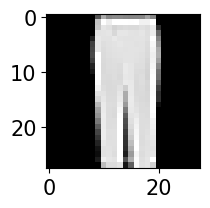

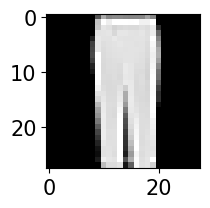

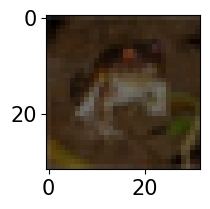

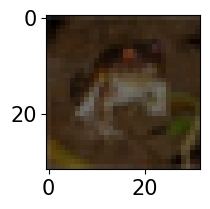

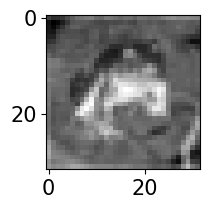

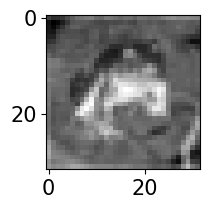

In [64]:
dotheory=True
m=0
s0=0

dataNames=['MNIST','Fashion','CIFAR','CIFARG']

#Ps=np.ceil(np.power(10,np.linspace(2,4,6))).astype(int)
#Ns=2*Ps
#Ps=np.power(2,np.linspace(4,12,6)).astype(int)
#Ns=5*Ps
Ps=np.power(2,np.linspace(7,10,3)).astype(int)
Ns=Ps*10

for dataName in dataNames[1:]:
    print('dataName')
    #for i,P in enumerate(Ps[4:6]):
    for i,P in enumerate(Ps[:-1]):
        N=Ns[i]
        #N=6*P
        seed=0
        X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed)  
        runTrial(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,m=m,dotheory=dotheory,s0=s0)
        

In [15]:
Y

DeviceArray([[ 0.9, -0.1, -0.1, ..., -0.1, -0.1, -0.1],
             [ 0.9, -0.1, -0.1, ..., -0.1, -0.1, -0.1],
             [ 0.9, -0.1, -0.1, ..., -0.1, -0.1, -0.1],
             ...,
             [-0.1, -0.1, -0.1, ..., -0.1, -0.1,  0.9],
             [-0.1, -0.1, -0.1, ..., -0.1, -0.1,  0.9],
             [-0.1, -0.1, -0.1, ..., -0.1, -0.1,  0.9]], dtype=float32)

In [29]:
def runTrialAC(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,x_test,m=0,dotheory=False,s0=0):
    resolution=100000000#100000000
    trapz_n=10000
    chunk_size=100000

    Ls=jnp.arange(2,20)
    #pas=[0.4999,0.2,0.1]
    pas=jnp.linspace(0.4999,0.01,20)
    taus=gp.getTau(jnp.array(pas))

    alpha=P/N

    errAf=np.zeros((jnp.shape(taus)[0],jnp.shape(Ls)[0]))
    errTf=np.copy(errAf)
    accAf=np.copy(errAf)
    Kaps=np.copy(errAf)
    Gams=np.copy(errAf)
    etas=np.zeros((jnp.shape(taus)[0],jnp.shape(Ls)[0],N))
    VT=np.zeros((jnp.shape(taus)[0],jnp.shape(Ls)[0],N,np.shape(Y)[1]))
    ERO=np.copy(etas)
    for j, tau in enumerate(taus):
        sigma=np.squeeze(gp.getosig(tau))
        converter=gp.getConverter_chunk_save_load(tau=tau,resolution=resolution,trapz_n=trapz_n,chunk_size=chunk_size,silence=False,home=home)

        if dotheory:
            load_names_te=gp.getSCK_fast_and_save(X,X,converter,mh0=0,mw0=0,mh=0,mw=m,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='test')
        else:
            load_names_tr=gp.getSCK_fast_and_save(x_train,x_train,converter,mh0=0,mw0=0,mh=0,mw=m,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='train')
            load_names_te=gp.getSCK_fast_and_save(x_train,X,converter,mh0=0,mw0=0,mh=0,mw=m,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='test')
            #load_names_te=gp.getSCK_fast_and_save(x_train,x_test,converter,mh0=0,mw0=0,mh=0,mw=m,sigma=sigma,L=jnp.max(Ls),input_unit_ball=False,home=home,label='test')

        for g, L in enumerate(Ls):
        #try:
            if dotheory:
                K=np.load(load_names_te[g])
                A=K[train_ID,:][:,train_ID]
                C=K[train_ID,:]
            else:
                K=0
                A=np.load(load_names_tr[g])
                C=np.load(load_names_te[g])
            
            K=K/jnp.max(A)
            C=C/jnp.max(A)
            A=A/jnp.max(A)
            

            #yr_test=gp.train_multi(A,A*0.0,C,C*0.0,y_train,corr=False,s0=s0)
            yr_test=gp.train_single_fast(A,C,y_train,s0=s0)
            
            
            errAf[j,g]=jnp.mean(jnp.square(yr_test-Y))
            accAf[j,g]=accuracy(getMax(yr_test),getMax(Y))
            print('err:{:.2e}, sigma:{:.2f}, pa:{:.2e}, m:{}, L:{}, '.format(errAf[j,g],sigma,gp.getPa(tau),m,L))

            if dotheory:
                #Phi_d,eta,_=jnp.linalg.svd(K)
                #M=np.sum(eta>0)
                M=N
                eta, Phi_d = jnp.linalg.eigh(K/N)
                inds = jnp.argsort(eta)[::-1]
                eta = jnp.abs(eta[inds] * (eta[inds] > 0))
                #print(eta)
                #Phi_d = Phi_d*jnp.sqrt(N)
                Phi_d = Phi_d[:,inds]#*jnp.sqrt(N)
                
                vteach=jnp.squeeze(jnp.matmul(Phi_d.T,Y))/np.sqrt(N)
                weight_sum=jnp.mean(jnp.square(vteach),axis=1)

                etas[j,g,:]=np.copy(eta)
                
                ka=solve_kappa(P, s0, eta)
                gam=jnp.sum(gamma_fn(P, ka, eta))#getgam(eta,P,ka)
                #gam=getgam(eta,P,ka)
                
                prefactor = ka**2/(1 - gam)
                noiseless = prefactor * (1/(P*eta[1:] + ka)**2)
                zero_mode_err = prefactor * (1/(2*P*eta[0]+ka)**2*(1+gam))
                #Erhos = jnp.concatenate([zero_mode_err,noiseless])
                Erhos = jnp.insert(noiseless,0,zero_mode_err)

                #Erhos=1/(1-gam) *  (ka**2)/(np.square(ka + P*eta ))
                Eg=np.squeeze(np.dot(Erhos,weight_sum))
                errTf[j,g]=np.mean(Eg)

                ###
                VT[j,g,:,:]=vteach
                ERO[j,g,:]=Erhos
                Kaps[j,g]=ka
                Gams[j,g]=gam
        #except:
        #    print('untrainable')
        del A
        del C
        del K
        del converter

    if dotheory:
        theory_or_not='exp_theory_'
    else:
        theory_or_not='exp_'

    filename='AC_'+'withacc_'+theory_or_not+dataName+'_P{}_N{}_m{}_s0{}'.format(P,N,m,s0)
    np.savez('./sweep_data/'+filename,P=P,N=N,m=m,s0=s0,Ls=Ls,pas=pas,resolution=resolution,trapz_n=trapz_n,chunk_size=chunk_size,errAf=errAf,errTf=errTf,accAf=accAf,etas=etas,VT=VT,ERO=ERO,Kaps=Kaps,Gams=Gams)



loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:6.96e-02, sigma:1.41, pa:5.00e-01, m:0, L:2, 
err:5.97e-02, sigma:1.41, pa:5.00e-01, m:0, L:3, 
err:5.47e-02, sigma:1.41, pa:5.00e-01, m:0, L:4, 
err:5.16e-02, sigma:1.41, pa:5.00e-01, m:0, L:5, 
err:4.94e-02, sigma:1.41, pa:5.00e-01, m:0, L:6, 
err:4.78e-02, sigma:1.41, pa:5.00e-01, m:0, L:7, 
err:4.66e-02, sigma:1.41, pa:5.00e-01, m:0, L:8, 
err:4.56e-02, sigma:1.41, pa:5.00e-01, m:0, L:9, 
err:4.48e-02, sigma:1.41, pa:5.00e-01, m:0, L:10, 
err:4.42e-02, sigma:1.41, pa:5.00e-01, m:0, L:11, 
err:4.36e-02, sigma:1.41, pa:5.00e-01, m:0, L:12, 
e

2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:6.48e-02, sigma:1.99, pa:3.45e-01, m:0, L:2, 
err:5.44e-02, sigma:1.99, pa:3.45e-01, m:0, L:3, 
err:4.91e-02, sigma:1.99, pa:3.45e-01, m:0, L:4, 
err:4.59e-02, sigma:1.99, pa:3.45e-01, m:0, L:5, 
err:4.37e-02, sigma:1.99, pa:3.45e-01, m:0, L:6, 
err:4.22e-02, sigma:1.99, pa:3.45e-01, m:0, L:7, 
err:4.12e-02, sigma:1.99, pa:3.45e-01, m:0, L:8, 
err:4.05e-02, sigma:1.99, pa:3.45e-01, m:0, L:9, 
err:4.00e-02, sigma:1.99, pa:3.45e-01, m:0, L:10, 
err:3.97e-02, sigma:1.99, pa:3.45e-01, m:0, L:11, 
err:3.95e-02, sigma:1.99, pa:3.45e-01, m:0, L:12, 
err:3.94e-02, sigma:1.99, pa:3.45e-01, m:0, L:13, 
err:3.94e-02, s

6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:6.01e-02, sigma:3.18, pa:1.90e-01, m:0, L:2, 
err:4.93e-02, sigma:3.18, pa:1.90e-01, m:0, L:3, 
err:4.41e-02, sigma:3.18, pa:1.90e-01, m:0, L:4, 
err:4.13e-02, sigma:3.18, pa:1.90e-01, m:0, L:5, 
err:3.99e-02, sigma:3.18, pa:1.90e-01, m:0, L:6, 
err:3.94e-02, sigma:3.18, pa:1.90e-01, m:0, L:7, 
err:3.95e-02, sigma:3.18, pa:1.90e-01, m:0, L:8, 
err:4.00e-02, sigma:3.18, pa:1.90e-01, m:0, L:9, 
err:4.06e-02, sigma:3.18, pa:1.90e-01, m:0, L:10, 
err:4.14e-02, sigma:3.18, pa:1.90e-01, m:0, L:11, 
err:4.23e-02, sigma:3.18, pa:1.90e-01, m:0, L:12, 
err:4.31e-02, sigma:3.18, pa:1.90e-01, m:0, L:13, 
err:4.38e-02, sigma:3.18, pa:1.90e-01, m:0, L:14, 
err:4.43e-02, sigma:3.18, pa:1.90e-01, m:0, L:15, 
err:4

11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:5.33e-02, sigma:9.91, pa:3.58e-02, m:0, L:2, 
err:4.26e-02, sigma:9.91, pa:3.58e-02, m:0, L:3, 
err:3.97e-02, sigma:9.91, pa:3.58e-02, m:0, L:4, 
err:4.06e-02, sigma:9.91, pa:3.58e-02, m:0, L:5, 
err:4.29e-02, sigma:9.91, pa:3.58e-02, m:0, L:6, 
err:4.45e-02, sigma:9.91, pa:3.58e-02, m:0, L:7, 
err:4.50e-02, sigma:9.91, pa:3.58e-02, m:0, L:8, 
err:4.51e-02, sigma:9.91, pa:3.58e-02, m:0, L:9, 
err:4.51e-02, sigma:9.91, pa:3.58e-02, m:0, L:10, 
err:4.51e-02, sigma:9.91, pa:3.58e-02, m:0, L:11, 
err:4.51e-02, sigma:9.91, pa:3.58e-02, m:0, L:12, 
err:4.51e-02, sigma:9.91, pa:3.58e-02, m:0, L:13, 
err:4.51e-02, sigma:9.91, pa:3.58e-02, m:0, L:14, 
err:4.51e-02, sigma:9.91, pa:3.58e-02, m:0, L:15, 
err:4.51e-02, sigma:9.91, pa:3.58e-02, m:0, L:16, 
err:4.51e-02, sigma:9.91, pa:3.58e-02, m:0, L:17, 
err:4.51e-02, sigma

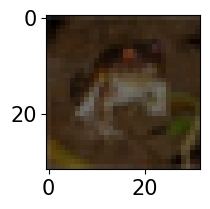

In [30]:
dotheory=True
m=0
s0=0

dataNames=['MNIST','Fashion','CIFAR','CIFARG']


Ps=np.ceil(np.power(10,np.linspace(2,4,6))).astype(int)
Ns=2*Ps

dataName='CIFAR'
#P=Ps[3]
P=600
N=1200
seed=0
X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed)  
runTrialAC(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,x_test,m=m,dotheory=dotheory,s0=s0)
        

In [ ]:
## Comparison to the google brain result

dotheory=False
zeromean=False
m=0
s0=0

dataNames=['MNIST','CIFAR']
#dataNames=['CIFAR','CIFARG']

Ps=np.array([100,200,500,1000,2000,5000,10000])

seeds=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
for seed in seeds:
    for dataName in dataNames:
        print(dataName)
        for i,P in enumerate(Ps):
            #seed=0
            N=int(10000+P)
            X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed,zeromean=zeromean)  
            runTrial(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,m=0,dotheory=False,
                     s0=0,sep=True,x_test=x_test,y_test=y_test,append='_seed'+str(seed))



MNIST
Download complete.
Save complete.
# of training images:60000
# of test images:10000
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:4.96e-02, sigma:1.41, pa:5.00e-01

done
err:4.71e-02, sigma:1.76, pa:3.97e-01, m:0, L:2, 
err:4.32e-02, sigma:1.76, pa:3.97e-01, m:0, L:3, 
err:4.23e-02, sigma:1.76, pa:3.97e-01, m:0, L:4, 
err:4.25e-02, sigma:1.76, pa:3.97e-01, m:0, L:5, 
err:4.32e-02, sigma:1.76, pa:3.97e-01, m:0, L:6, 
err:4.43e-02, sigma:1.76, pa:3.97e-01, m:0, L:7, 
err:4.56e-02, sigma:1.76, pa:3.97e-01, m:0, L:8, 
err:4.72e-02, sigma:1.76, pa:3.97e-01, m:0, L:9, 
err:4.88e-02, sigma:1.76, pa:3.97e-01, m:0, L:10, 
err:5.06e-02, sigma:1.76, pa:3.97e-01, m:0, L:11, 
err:5.24e-02, sigma:1.76, pa:3.97e-01, m:0, L:12, 
err:5.43e-02, sigma:1.76, pa:3.97e-01, m:0, L:13, 
err:5.62e-02, sigma:1.76, pa:3.97e-01, m:0, L:14, 
err:5.81e-02, sigma:1.76, pa:3.97e-01, m:0, L:15, 
err:6.01e-02, sigma:1.76, pa:3.97e-01, m:0, L:16, 
err:6.20e-02, sigma:1.76, pa:3.97e-01, m:0, L:17, 
err:6.39e-02, sigma:1.76, pa:3.97e-01, m:0, L:18, 
err:6.57e-02, sigma:1.76, pa:3.97e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel sav

7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:4.44e-02, sigma:2.45, pa:2.68e-01, m:0, L:2, 
err:4.18e-02, sigma:2.45, pa:2.68e-01, m:0, L:3, 
err:4.28e-02, sigma:2.45, pa:2.68e-01, m:0, L:4, 
err:4.56e-02, sigma:2.45, pa:2.68e-01, m:0, L:5, 
err:4.96e-02, sigma:2.45, pa:2.68e-01, m:0, L:6, 
err:5.44e-02, sigma:2.45, pa:2.68e-01, m:0, L:7, 
err:5.9

err:9.04e-02, sigma:3.55, pa:1.65e-01, m:0, L:14, 
err:9.05e-02, sigma:3.55, pa:1.65e-01, m:0, L:15, 
err:9.05e-02, sigma:3.55, pa:1.65e-01, m:0, L:16, 
err:9.06e-02, sigma:3.55, pa:1.65e-01, m:0, L:17, 
err:9.06e-02, sigma:3.55, pa:1.65e-01, m:0, L:18, 
err:9.06e-02, sigma:3.55, pa:1.65e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel 

15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:4.10e-02, sigma:9.91, pa:3.58e-02, m:0, L:2, 
err:5.36e-02, sigma:9.91, pa:3.58e-02, m:0, L:3, 
err:7.65e-02, sigma:9.91, pa:3.58e-02, m:0, L:4, 
err:8.81e-02, sigma:9.91, pa:3.58e-02, m:0, L:5, 
err:9.07e-02, sigma:9.91, pa:3.58e-02, m:0, L:6, 
err:9.11e-02, sigma:9.91, pa:3.58e-02, m:0, L:7, 
err:9.11e-02, sigma:9.91, pa:3.58e-02, m:0, L:8, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:9, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:10, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:11, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:12, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:13, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:14, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:15, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:16, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:17, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:18, 
err:9.12e-02, sigma:9.91, pa:3.58e-02, m:0, L:19, 
loaded from a

err:4.34e-02, sigma:1.57, pa:4.48e-01, m:0, L:18, 
err:4.43e-02, sigma:1.57, pa:4.48e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:4.01e-02, sigma:1.66,

err:3.45e-02, sigma:2.12, pa:3.19e-01, m:0, L:4, 
err:3.55e-02, sigma:2.12, pa:3.19e-01, m:0, L:5, 
err:3.73e-02, sigma:2.12, pa:3.19e-01, m:0, L:6, 
err:3.96e-02, sigma:2.12, pa:3.19e-01, m:0, L:7, 
err:4.24e-02, sigma:2.12, pa:3.19e-01, m:0, L:8, 
err:4.56e-02, sigma:2.12, pa:3.19e-01, m:0, L:9, 
err:4.90e-02, sigma:2.12, pa:3.19e-01, m:0, L:10, 
err:5.28e-02, sigma:2.12, pa:3.19e-01, m:0, L:11, 
err:5.66e-02, sigma:2.12, pa:3.19e-01, m:0, L:12, 
err:6.05e-02, sigma:2.12, pa:3.19e-01, m:0, L:13, 
err:6.44e-02, sigma:2.12, pa:3.19e-01, m:0, L:14, 
err:6.80e-02, sigma:2.12, pa:3.19e-01, m:0, L:15, 
err:7.14e-02, sigma:2.12, pa:3.19e-01, m:0, L:16, 
err:7.45e-02, sigma:2.12, pa:3.19e-01, m:0, L:17, 
err:7.73e-02, sigma:2.12, pa:3.19e-01, m:0, L:18, 
err:7.97e-02, sigma:2.12, pa:3.19e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer 

12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:3.54e-02, sigma:3.18, pa:1.90e-01, m:0, L:2, 
err:3.40e-02, sigma:3.18, pa:1.90e-01, m:0, L:3, 
err:3.68e-02, sigma:3.18, pa:1.90e-01, m:0, L:4, 
err:4.23e-02, sigma:3.18, pa:1.90e-01, m:0, L:5, 
err:4.99e-02, sigma:3.18, pa:1.90e-01, m:0, L:6, 
err:5.88e-02, sigma:3.18, pa:1.90e-01, m:0, L:7, 
err:6.77e-02, sigma:3.18, pa:1.90e-01, m:0, L:8, 
err:7.54e-02, sigma:3.18, pa:1.90e-01, m:0, L:9, 
err:8.12e-02, sigma:3.18

err:9.05e-02, sigma:5.53, pa:8.74e-02, m:0, L:17, 
err:9.05e-02, sigma:5.53, pa:8.74e-02, m:0, L:18, 
err:9.05e-02, sigma:5.53, pa:8.74e-02, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17t

9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:3.01e-02, sigma:1.49, pa:4.74e-01, m:0, L:2, 
err:2.74e-02, sigma:1.49, pa:4.74e-01, m:0, L:3, 
err:2.66e-02, sigma:1.49, pa:4.74e-01, m:0, L:4, 
err:2.63e-02, sigma:1.49, pa:4.74e-01, m:0, L:5, 
err:2.63e-02, sigma:1.49, pa:4.74e-01, m:0, L:6, 
err:2.65e-02, sigma:1.49, pa:4.74e-01, m:0, L:7, 
err:2.67e-02, sigma:1.49, pa:4.74e-01, m:0, L:8, 
err:2.70e-02, sigma:1.49, pa:4.74e-01, m:0, L:9, 
err:2.73e-02, sigma:1.49, pa:4.74e-01, m:0, L:10, 
err:2.76e-02, sigma:1.49, pa:4.74e-01, m:0, L:11, 
err:2.79e-02, sigma:1.49, pa:4.74e-01, m:0, L:12, 
err:2.83e-02, sigma:1.49, pa:4.74e-01, m:0, L:13, 
err:2.87e-02, sigma:1.49, pa:4.74e-01, m:0, L:14, 
err:2.90e-02, sigma:1.49, pa:4.74e-01, m:0, L:15, 
err:2.94e-02, sigma:1.49, pa:4.74e-01, m:0, L:16, 
err:2.98e-02, sigma:1.4

In [35]:
Ns

array([  200,   504,  1262,  3170,  7964, 20000])

MNIST
Download complete.
Save complete.
# of training images:60000
# of test images:10000
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.12e-02, sigma:1.41, pa:5.00e-01

16th layer kernel saved
17th layer kernel saved
done
err:1.08e-02, sigma:1.76, pa:3.97e-01, m:0, L:2, 
err:9.93e-03, sigma:1.76, pa:3.97e-01, m:0, L:3, 
err:9.77e-03, sigma:1.76, pa:3.97e-01, m:0, L:4, 
err:9.85e-03, sigma:1.76, pa:3.97e-01, m:0, L:5, 
err:1.00e-02, sigma:1.76, pa:3.97e-01, m:0, L:6, 
err:1.03e-02, sigma:1.76, pa:3.97e-01, m:0, L:7, 
err:1.06e-02, sigma:1.76, pa:3.97e-01, m:0, L:8, 
err:1.10e-02, sigma:1.76, pa:3.97e-01, m:0, L:9, 
err:1.14e-02, sigma:1.76, pa:3.97e-01, m:0, L:10, 
err:1.18e-02, sigma:1.76, pa:3.97e-01, m:0, L:11, 
err:1.22e-02, sigma:1.76, pa:3.97e-01, m:0, L:12, 
err:1.27e-02, sigma:1.76, pa:3.97e-01, m:0, L:13, 
err:1.32e-02, sigma:1.76, pa:3.97e-01, m:0, L:14, 
err:1.37e-02, sigma:1.76, pa:3.97e-01, m:0, L:15, 
err:1.43e-02, sigma:1.76, pa:3.97e-01, m:0, L:16, 
err:1.49e-02, sigma:1.76, pa:3.97e-01, m:0, L:17, 
err:1.55e-02, sigma:1.76, pa:3.97e-01, m:0, L:18, 
err:1.62e-02, sigma:1.76, pa:3.97e-01, m:0, L:19, 
loaded from a file
0th layer kernel s

6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.03e-02, sigma:2.45, pa:2.68e-01, m:0, L:2, 
err:9.64e-03, sigma:2.45, pa:2.68e-01, m:0, L:3, 
err:9.85e-03, sigma:2.45, pa:2.68e-01, m:0, L:4, 
err:1.04e-02, sigma:2.45, pa:2.68e-01, m:0, L:5, 
err:1.13e-02, sigma:2.45, pa:2.68e-01, m:0, L:6, 
err:1.25e-02, sigma:2.45, pa:2.68e

err:4.26e-02, sigma:3.55, pa:1.65e-01, m:0, L:12, 
err:4.38e-02, sigma:3.55, pa:1.65e-01, m:0, L:13, 
err:4.45e-02, sigma:3.55, pa:1.65e-01, m:0, L:14, 
err:4.48e-02, sigma:3.55, pa:1.65e-01, m:0, L:15, 
err:4.49e-02, sigma:3.55, pa:1.65e-01, m:0, L:16, 
err:4.50e-02, sigma:3.55, pa:1.65e-01, m:0, L:17, 
err:4.50e-02, sigma:3.55, pa:1.65e-01, m:0, L:18, 
err:4.51e-02, sigma:3.55, pa:1.65e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th laye

10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:9.41e-03, sigma:9.91, pa:3.58e-02, m:0, L:2, 
err:1.18e-02, sigma:9.91, pa:3.58e-02, m:0, L:3, 
err:2.07e-02, sigma:9.91, pa:3.58e-02, m:0, L:4, 
err:3.53e-02, sigma:9.91, pa:3.58e-02, m:0, L:5, 
err:4.31e-02, sigma:9.91, pa:3.58e-02, m:0, L:6, 
err:4.47e-02, sigma:9.91, pa:3.58e-02, m:0, L:7, 
err:4.50e-02, sigma:9.91, pa:3.58e-02, m:0, L:8, 
err:4.50e-02, sigma:9.91, pa:3.58e-02, m:0, L:9, 
err:4.51e-02, sigma:9.91, pa:3.58e-02, m:0, L:10, 
err:4.52e-02, sigma:9.91, pa:3.58e-02, m:0, L:11, 
err:4.54e-02, sigma:9.91, pa:3.58e-02, m:0, L:12, 
err:4.55e-02, sigma:9.91, pa:3.58e-02, m:0, L:13, 
err:4.56e-02, sigma:9.91, pa:3.58e-02, m:0, L:14, 
err:4.56e-02, sigma:9.91, pa:3.58e-02, m:0, L:15, 
err:4.56e-02, sigma:9.91, pa:3.58e-02, m:0, L:16, 
err:4.56e-02, sigma:9.91, pa:3.58e-02, m:0, L:

err:1.36e-02, sigma:1.57, pa:4.48e-01, m:0, L:17, 
err:1.39e-02, sigma:1.57, pa:4.48e-01, m:0, L:18, 
err:1.43e-02, sigma:1.57, pa:4.48e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17t

err:9.91e-03, sigma:2.12, pa:3.19e-01, m:0, L:4, 
err:1.02e-02, sigma:2.12, pa:3.19e-01, m:0, L:5, 
err:1.07e-02, sigma:2.12, pa:3.19e-01, m:0, L:6, 
err:1.14e-02, sigma:2.12, pa:3.19e-01, m:0, L:7, 
err:1.21e-02, sigma:2.12, pa:3.19e-01, m:0, L:8, 
err:1.31e-02, sigma:2.12, pa:3.19e-01, m:0, L:9, 
err:1.41e-02, sigma:2.12, pa:3.19e-01, m:0, L:10, 
err:1.53e-02, sigma:2.12, pa:3.19e-01, m:0, L:11, 
err:1.66e-02, sigma:2.12, pa:3.19e-01, m:0, L:12, 
err:1.81e-02, sigma:2.12, pa:3.19e-01, m:0, L:13, 
err:1.98e-02, sigma:2.12, pa:3.19e-01, m:0, L:14, 
err:2.16e-02, sigma:2.12, pa:3.19e-01, m:0, L:15, 
err:2.35e-02, sigma:2.12, pa:3.19e-01, m:0, L:16, 
err:2.55e-02, sigma:2.12, pa:3.19e-01, m:0, L:17, 
err:2.76e-02, sigma:2.12, pa:3.19e-01, m:0, L:18, 
err:2.97e-02, sigma:2.12, pa:3.19e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer 

12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.00e-02, sigma:3.18, pa:1.90e-01, m:0, L:2, 
err:9.64e-03, sigma:3.18, pa:1.90e-01, m:0, L:3, 
err:1.04e-02, sigma:3.18, pa:1.90e-01, m:0, L:4, 
err:1.18e-02, sigma:3.18, pa:1.90e-01, m:0, L:5, 
err:1.40e-02, sigma:3.18, pa:1.90e-01, m:0, L:6, 
err:1.71e-02, sigma:3.18, pa:1.90e-01, m:0, L:7, 
err:2.11e-02, sigma:3.18, pa:1.90e-01, m:0, L:8, 
err:2.58e-02, sigma:3.18, pa:1.90e-01, m:0, L:9, 
err:3.09e-02, sigma:3.18

err:4.51e-02, sigma:5.53, pa:8.74e-02, m:0, L:17, 
err:4.51e-02, sigma:5.53, pa:8.74e-02, m:0, L:18, 
err:4.51e-02, sigma:5.53, pa:8.74e-02, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17t

10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:3.84e-02, sigma:1.49, pa:4.74e-01, m:0, L:2, 
err:3.88e-02, sigma:1.49, pa:4.74e-01, m:0, L:3, 
err:4.04e-02, sigma:1.49, pa:4.74e-01, m:0, L:4, 
err:4.24e-02, sigma:1.49, pa:4.74e-01, m:0, L:5, 
err:4.45e-02, sigma:1.49, pa:4.74e-01, m:0, L:6, 
err:4.68e-02, sigma:1.49, pa:4.74e-01, m:0, L:7, 
err:4.91e-02, sigma:1.49, pa:4.74e-01, m:0, L:8, 
err:5.14e-02, sigma:1.49, pa:4.74e-01, m:0, L:9, 
err:5.36e-02, sigma:1.49, pa:4.74e-01, m:0, L:10, 
err:5.57e-02, sigma:1.49, pa:4.74e-01, m:0, L:11, 
err:5.77e-02, sigma:1.49, pa:4.74e-01, m:0, L:12, 
err:5.97e-02, sigma:1.49, pa:4.74e-01, m:0, L:13, 
err:6.15e-02, sigma:1.49, pa:4.74e-01, m:0, L:14, 
err:6.32e-02, sigma:1.49, pa:4.74e-01, m:0, L:15, 
err:6.49e-02, sigma:1.49, pa:4.74e-01, m:0, L:16, 
err:6.64e-02, sigma:1.49, pa:4.74e-01, m:0, L:

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:3.08e-02, sigma:1.99, pa:3.45e-01, m:0, L:2, 
err:2.90e-02, sigma:1.99, pa:3.45e-01, m:0, L:3, 
err:2.88e-02, sigma:1.99, pa:3.45e-01, m:0, L:

err:3.45e-02, sigma:2.65, pa:2.42e-01, m:0, L:9, 
err:3.92e-02, sigma:2.65, pa:2.42e-01, m:0, L:10, 
err:4.40e-02, sigma:2.65, pa:2.42e-01, m:0, L:11, 
err:4.85e-02, sigma:2.65, pa:2.42e-01, m:0, L:12, 
err:5.22e-02, sigma:2.65, pa:2.42e-01, m:0, L:13, 
err:5.52e-02, sigma:2.65, pa:2.42e-01, m:0, L:14, 
err:5.74e-02, sigma:2.65, pa:2.42e-01, m:0, L:15, 
err:5.89e-02, sigma:2.65, pa:2.42e-01, m:0, L:16, 
err:6.00e-02, sigma:2.65, pa:2.42e-01, m:0, L:17, 
err:6.07e-02, sigma:2.65, pa:2.42e-01, m:0, L:18, 
err:6.12e-02, sigma:2.65, pa:2.42e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved

4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:1.43e-02, sigma:4.63, pa:1.13e-01, m:0, L:2, 
err:1.29e-02, sigma:4.63, pa:1.13e-01, m:0, L:3, 
err:1.48e-02, sigma:4.63, pa:1.13e-01, m:0, L:4, 
err:1.96e-02, sigma:4.63, pa:1.13e-01, m:0, L:5, 
err:2.72e-02, sigma:4.63, pa:1.13e-01, m:0, L:6, 
err:3.60e-02, sigma:4.63, pa:1.13e-01, m:0, L:7, 
err:4.27e-02, sigma:4.63, pa:1.13e-01, m:0, L:8, 
err:4.63e-02, sigma:4.63, pa:1.13e-01, m:0, L:9, 
err:4.78e-02, sigma:4.63, pa:1.13e-01, m:0, L:10, 
err:4.84e-02, sigma:4.63, pa:1.13e-01, m:0, L:11, 
err:4.87e-02, sigma:4.63, pa:1.13e-01, m:0, L:12, 
err:4.88e-02, sigma:4.63, pa:1.13e-01, m:0, L:13, 
err:4.89e-02, sigma:4.63, pa:1.13e-01, m:0, L:14, 
err:4.90e-

err:4.51e-02, sigma:21.74, pa:1.00e-02, m:0, L:18, 
err:4.51e-02, sigma:21.74, pa:1.00e-02, m:0, L:19, 
Download complete.
Save complete.
# of training images:60000
# of test images:10000
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kerne

12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:8.45e-02, sigma:1.76, pa:3.97e-01, m:0, L:2, 
err:8.57e-02, sigma:1.76, pa:3.97e-01, m:0, L:3, 
err:8.65e-02, sigma:1.76, pa:3.97e-01, m:0, L:4, 
err:8.72e-02, sigma:1.76, pa:3.97e-01, m:0, L:5, 
err:8.78e-02, sigma:1.76, pa:3.97e-01, m:0, L:6, 
err:8.82e-02, sigma:1.76, pa:3.97e-01, m:0, L:7, 
err:8.86e-02, sigma:1.76, pa:3.97e-01, m:0, L:8, 
err:8.88e-02, sigma:1.76, pa:3.97e-01, m:0, L:9, 
err:8.91e-02, sigma:1.76, pa:3.97e-01, m:0, L:10, 
err:8.93e-02, sigma:1.76, pa:3.97e-01, m:0, L:11, 
err:8.94e-02, sigma:1.76, pa:3.97e-01, m:0, L:12, 
err:8.96e-02, sigma:1.76, pa:3.97e-01, m:0, L:13, 
err:8.97e-02, sigma:1.76, pa:3.97e-01, m:0, L:14, 
err:8.98e-02, sigma:1.76, pa:3.97e-01, m:0, L:15, 
err:8.99e-02, sigma:1.76, pa:3.97e-01, m:0, L:16, 
err:9.00e-02, sigma:1.76, pa:3.97e-01, m:0, L:17, 
err:9.00e-02, sigma:1.76, pa:3.97e-01, m:0,

0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:7.82e-02, sigma:2.45, pa:2.68e-01, m:0, L:2, 
err:8.01e-02, sigma:2.45, pa:2.68e-01, m:0, L:3, 
err:8.20e-02, sigma:2.45, pa:2.68e-01, m:0, L:

err:8.94e-02, sigma:3.55, pa:1.65e-01, m:0, L:11, 
err:8.95e-02, sigma:3.55, pa:1.65e-01, m:0, L:12, 
err:8.95e-02, sigma:3.55, pa:1.65e-01, m:0, L:13, 
err:8.95e-02, sigma:3.55, pa:1.65e-01, m:0, L:14, 
err:8.95e-02, sigma:3.55, pa:1.65e-01, m:0, L:15, 
err:8.96e-02, sigma:3.55, pa:1.65e-01, m:0, L:16, 
err:8.96e-02, sigma:3.55, pa:1.65e-01, m:0, L:17, 
err:8.96e-02, sigma:3.55, pa:1.65e-01, m:0, L:18, 
err:8.96e-02, sigma:3.55, pa:1.65e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th

8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:3.79e-02, sigma:9.91, pa:3.58e-02, m:0, L:2, 
err:4.76e-02, sigma:9.91, pa:3.58e-02, m:0, L:3, 
err:6.80e-02, sigma:9.91, pa:3.58e-02, m:0, L:4, 
err:7.87e-02, sigma:9.91, pa:3.58e-02, m:0, L:5, 
err:8.10e-02, sigma:9.91, pa:3.58e-02, m:0, L:6, 
err:8.13e-02, sigma:9.91, pa:3.58e-02, m:0, L:7, 
err:8.14e-02, sigma:9.91, pa:3.58e-02, m:0, L:8, 
err:8.14e-02, sigma:9.91, pa:3.58e-02, m:0, L:9, 
err:8.14e-02, sigma:9.91, pa:3.58e-02, m:0, L:10, 
err:8.14e-02, sigma:9.91, pa:3.58e-02, m:0, L:11, 
err:8.15e-02, sigma:9.91, pa:3.58e-02, m:0, L:12, 
err:8.15e-02, sigma:9.91, pa:3.58e-02, m:0, L:13, 
err:8.15e-02, sigma:9.91, pa:3.58e-02, m:0, L:14, 
err:8.15e-02, sigma:9.91, pa:3.58e-02, m:0, L:15, 
err:8.15e-02, sigma:9.91, pa:3.58e-02, m:0, L:16, 


0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:5.85e-02, sigma:1.66, pa:4.23e-01, m:0, L:2, 
err:5.18e-02, sigma:1.66, pa:4.23e-01, m:0, L:3, 
err:4.81e-02, sigma:1.66, pa:4.23e-01, m:0, L:

err:3.88e-02, sigma:2.12, pa:3.19e-01, m:0, L:9, 
err:3.84e-02, sigma:2.12, pa:3.19e-01, m:0, L:10, 
err:3.83e-02, sigma:2.12, pa:3.19e-01, m:0, L:11, 
err:3.82e-02, sigma:2.12, pa:3.19e-01, m:0, L:12, 
err:3.83e-02, sigma:2.12, pa:3.19e-01, m:0, L:13, 
err:3.84e-02, sigma:2.12, pa:3.19e-01, m:0, L:14, 
err:3.86e-02, sigma:2.12, pa:3.19e-01, m:0, L:15, 
err:3.89e-02, sigma:2.12, pa:3.19e-01, m:0, L:16, 
err:3.92e-02, sigma:2.12, pa:3.19e-01, m:0, L:17, 
err:3.95e-02, sigma:2.12, pa:3.19e-01, m:0, L:18, 
err:3.98e-02, sigma:2.12, pa:3.19e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved

4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:5.61e-02, sigma:3.18, pa:1.90e-01, m:0, L:2, 
err:4.70e-02, sigma:3.18, pa:1.90e-01, m:0, L:3, 
err:4.24e-02, sigma:3.18, pa:1.90e-01, m:0, L:4, 
err:4.00e-02, sigma:3.18, pa:1.90e-01, m:0, L:5, 
err:3.87e-02, sigma:3.18, pa:1.90e-01, m:0, L:6, 
err:3.83e-02, sigma:3.18, pa:1.90e-01, m:0, L:7, 
err:3.84e-02, sigma:3.18, pa:1.90e-01, m:0, L:8, 
err:3.89e-02, sigma:3.18, pa:1.90e-01, m:0, L:9, 
err:3.96e-02, sigma:3.18, pa:1.90e-01, m:0, L:10, 
err:4.05e-02, sigma:3.18, pa:1.90e-01, m:0, L:11, 
err:4.14e-02, sigma:3.18, pa:1.90e-01, m:0, L:12, 
err:4.23e-02, sigma:3.18, pa:1.90e-01, m:0, L:13, 
err:4.31e-02, sigma:3.18, pa:1.90e-01, m:0, L:14, 
err:4.38e-

loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:5.23e-02, sigma:6.98, pa:6.16e-02, m:0, L:2, 
err:4.26e-02, sigma:6.98, pa:6.16e-02, m:0, L:3, 
err:3.90e-02, sigma:6.98, p

err:5.95e-02, sigma:1.49, pa:4.74e-01, m:0, L:11, 
err:5.95e-02, sigma:1.49, pa:4.74e-01, m:0, L:12, 
err:5.96e-02, sigma:1.49, pa:4.74e-01, m:0, L:13, 
err:5.97e-02, sigma:1.49, pa:4.74e-01, m:0, L:14, 
err:5.99e-02, sigma:1.49, pa:4.74e-01, m:0, L:15, 
err:6.00e-02, sigma:1.49, pa:4.74e-01, m:0, L:16, 
err:6.02e-02, sigma:1.49, pa:4.74e-01, m:0, L:17, 
err:6.04e-02, sigma:1.49, pa:4.74e-01, m:0, L:18, 
err:6.06e-02, sigma:1.49, pa:4.74e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th

8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:5.94e-02, sigma:1.99, pa:3.45e-01, m:0, L:2, 
err:5.40e-02, sigma:1.99, pa:3.45e-01, m:0, L:3, 
err:5.02e-02, sigma:1.99, pa:3.45e-01, m:0, L:4, 
err:4.73e-02, sigma:1.99, pa:3.45e-01, m:0, L:5, 
err:4.51e-02, sigma:1.99, pa:3.45e-01, m:0, L:6, 
err:4.35e-02, sigma:1.99, pa:3.45e-01, m:0, L:7, 
err:4.22e-02, sigma:1.99, pa:3.45e-01, m:0, L:8, 
err:4.13e-02, sigma:1.99, pa:3.45e-01, m:0, L:9, 
err:4.07e-02, sigma:1.99, pa:3.45e-01, m:0, L:10, 
err:4.02e-02, sigma:1.99, pa:3.45e-01, m:0, L:11, 
err:3.99e-02, sigma:1.99, pa:3.45e-01, m:0, L:12, 
err:3.98e-02, sigma:1.99, pa:3.45e-01, m:0, L:13, 
err:3.97e-02, sigma:1.99, pa:3.45e-01, m:0, L:14, 
err:3.97e-02, sigma:1.99, pa:3.45e-01, m:0, L:15, 
err:3.98e-02, sigma:1.99, pa:3.45e-01, m:0, L:16, 


0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:5.27e-02, sigma:2.89, pa:2.16e-01, m:0, L:2, 
err:4.62e-02, sigma:2.89, pa:2.16e-01, m:0, L:3, 
err:4.26e-02, sigma:2.89, pa:2.16e-01, m:0, L:

err:4.34e-02, sigma:4.63, pa:1.13e-01, m:0, L:10, 
err:4.43e-02, sigma:4.63, pa:1.13e-01, m:0, L:11, 
err:4.47e-02, sigma:4.63, pa:1.13e-01, m:0, L:12, 
err:4.49e-02, sigma:4.63, pa:1.13e-01, m:0, L:13, 
err:4.50e-02, sigma:4.63, pa:1.13e-01, m:0, L:14, 
err:4.51e-02, sigma:4.63, pa:1.13e-01, m:0, L:15, 
err:4.54e-02, sigma:4.63, pa:1.13e-01, m:0, L:16, 
err:4.61e-02, sigma:4.63, pa:1.13e-01, m:0, L:17, 
err:4.75e-02, sigma:4.63, pa:1.13e-01, m:0, L:18, 
err:4.94e-02, sigma:4.63, pa:1.13e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel save

4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:8.47e-02, sigma:1.41, pa:5.00e-01, m:0, L:2, 
err:8.50e-02, sigma:1.41, pa:5.00e-01, m:0, L:3, 
err:8.53e-02, sigma:1.41, pa:5.00e-01, m:0, L:4, 
err:8.57e-02, sigma:1.41, pa:5.00e-01, m:0, L:5, 
err:8.60e-02, sigma:1.41, pa:5.00e-01, m:0, L:6, 
err:8.63e-02, sigma:1.41, pa:5.00e-01, m:0, L:7, 
err:8.66e-02, sigma:1.41, pa:5.00e-01, m:0, L:8, 
err:8.69e-02, sigma:1.41, pa:5.00e-01, m:0, L:9, 
err:8.71e-02, sigma:1.41, pa:5.00e-01, m:0, L:10, 
err:8.73e-02, sigma:1.41, pa:5.00e-01, m:0, L:11, 
err:8.75e-02, sigma:1.41, pa:5.00e-01, m:0, L:12, 
err:8.77e-02, sigma:1.41, pa:5.00e-01, m:0, L:13, 
err:8.79e-02, sigma:1.41, pa:5.00e-01, m:0, L:14, 
err:8.81e-

err:8.43e-02, sigma:1.76, pa:3.97e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:8.25e-02, sigma:1.87, pa:3.71e-01, m:0, L:2, 
err:8.21e-02, sigma:1.87, 

err:7.52e-02, sigma:2.45, pa:2.68e-01, m:0, L:11, 
err:7.57e-02, sigma:2.45, pa:2.68e-01, m:0, L:12, 
err:7.64e-02, sigma:2.45, pa:2.68e-01, m:0, L:13, 
err:7.71e-02, sigma:2.45, pa:2.68e-01, m:0, L:14, 
err:7.78e-02, sigma:2.45, pa:2.68e-01, m:0, L:15, 
err:7.84e-02, sigma:2.45, pa:2.68e-01, m:0, L:16, 
err:7.89e-02, sigma:2.45, pa:2.68e-01, m:0, L:17, 
err:7.93e-02, sigma:2.45, pa:2.68e-01, m:0, L:18, 
err:7.97e-02, sigma:2.45, pa:2.68e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th

8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:7.47e-02, sigma:4.01, pa:1.39e-01, m:0, L:2, 
err:7.01e-02, sigma:4.01, pa:1.39e-01, m:0, L:3, 
err:6.57e-02, sigma:4.01, pa:1.39e-01, m:0, L:4, 
err:6.23e-02, sigma:4.01, pa:1.39e-01, m:0, L:5, 
err:6.06e-02, sigma:4.01, pa:1.39e-01, m:0, L:6, 
err:6.04e-02, sigma:4.01, pa:1.39e-01, m:0, L:7, 
err:6.13e-02, sigma:4.01, pa:1.39e-01, m:0, L:8, 
err:6.27e-02, sigma:4.01, pa:1.39e-01, m:0, L:9, 
err:6.41e-02, sigma:4.01, pa:1.39e-01, m:0, L:10, 
err:6.51e-02, sigma:4.01, pa:1.39e-01, m:0, L:11, 
err:6.57e-02, sigma:4.01, pa:1.39e-01, m:0, L:12, 
err:6.60e-02, sigma:4.01, pa:1.39e-01, m:0, L:13, 
err:6.61e-02, sigma:4.01, pa:1.39e-01, m:0, L:14, 
err:6.62e-02, sigma:4.01, pa:1.39e-01, m:0, L:15, 
err:6.62e-02, sigma:4.01, pa:1.39e-01, m:0, L:16, 


0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:4.66e-02, sigma:21.74, pa:1.00e-02, m:0, L:2, 
err:3.95e-02, sigma:21.74, pa:1.00e-02, m:0, L:3, 
err:3.98e-02, sigma:21.74, pa:1.00e-02, m:0,

err:9.32e-02, sigma:1.66, pa:4.23e-01, m:0, L:11, 
err:9.32e-02, sigma:1.66, pa:4.23e-01, m:0, L:12, 
err:9.32e-02, sigma:1.66, pa:4.23e-01, m:0, L:13, 
err:9.32e-02, sigma:1.66, pa:4.23e-01, m:0, L:14, 
err:9.32e-02, sigma:1.66, pa:4.23e-01, m:0, L:15, 
err:9.32e-02, sigma:1.66, pa:4.23e-01, m:0, L:16, 
err:9.32e-02, sigma:1.66, pa:4.23e-01, m:0, L:17, 
err:9.32e-02, sigma:1.66, pa:4.23e-01, m:0, L:18, 
err:9.32e-02, sigma:1.66, pa:4.23e-01, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th

8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:9.15e-02, sigma:2.27, pa:2.94e-01, m:0, L:2, 
err:9.16e-02, sigma:2.27, pa:2.94e-01, m:0, L:3, 
err:9.17e-02, sigma:2.27, pa:2.94e-01, m:0, L:4, 
err:9.18e-02, sigma:2.27, pa:2.94e-01, m:0, L:5, 
err:9.20e-02, sigma:2.27, pa:2.94e-01, m:0, L:6, 
err:9.21e-02, sigma:2.27, pa:2.94e-01, m:0, L:7, 
err:9.23e-02, sigma:2.27, pa:2.94e-01, m:0, L:8, 
err:9.25e-02, sigma:2.27, pa:2.94e-01, m:0, L:9, 
err:9.26e-02, sigma:2.27, pa:2.94e-01, m:0, L:10, 
err:9.28e-02, sigma:2.27, pa:2.94e-01, m:0, L:11, 
err:9.29e-02, sigma:2.27, pa:2.94e-01, m:0, L:12, 
err:9.30e-02, sigma:2.27, pa:2.94e-01, m:0, L:13, 
err:9.31e-02, sigma:2.27, pa:2.94e-01, m:0, L:14, 
err:9.31e-02, sigma:2.27, pa:2.94e-01, m:0, L:15, 
err:9.32e-02, sigma:2.27, pa:2.94e-01, m:0, L:16, 


0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel saved
16th layer kernel saved
17th layer kernel saved
done
err:8.96e-02, sigma:3.55, pa:1.65e-01, m:0, L:2, 
err:8.96e-02, sigma:3.55, pa:1.65e-01, m:0, L:3, 
err:8.98e-02, sigma:3.55, pa:1.65e-01, m:0, L:

err:9.21e-02, sigma:6.98, pa:6.16e-02, m:0, L:8, 
err:9.21e-02, sigma:6.98, pa:6.16e-02, m:0, L:9, 
err:9.22e-02, sigma:6.98, pa:6.16e-02, m:0, L:10, 
err:9.22e-02, sigma:6.98, pa:6.16e-02, m:0, L:11, 
err:9.22e-02, sigma:6.98, pa:6.16e-02, m:0, L:12, 
err:9.22e-02, sigma:6.98, pa:6.16e-02, m:0, L:13, 
err:9.22e-02, sigma:6.98, pa:6.16e-02, m:0, L:14, 
err:9.22e-02, sigma:6.98, pa:6.16e-02, m:0, L:15, 
err:9.22e-02, sigma:6.98, pa:6.16e-02, m:0, L:16, 
err:9.22e-02, sigma:6.98, pa:6.16e-02, m:0, L:17, 
err:9.22e-02, sigma:6.98, pa:6.16e-02, m:0, L:18, 
err:9.22e-02, sigma:6.98, pa:6.16e-02, m:0, L:19, 
loaded from a file
0th layer kernel saved
1th layer kernel saved
2th layer kernel saved
3th layer kernel saved
4th layer kernel saved
5th layer kernel saved
6th layer kernel saved
7th layer kernel saved
8th layer kernel saved
9th layer kernel saved
10th layer kernel saved
11th layer kernel saved
12th layer kernel saved
13th layer kernel saved
14th layer kernel saved
15th layer kernel sav

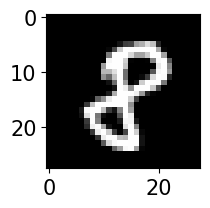

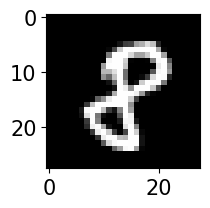

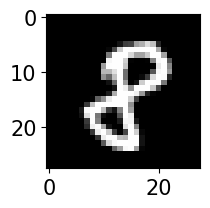

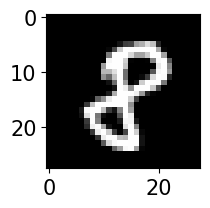

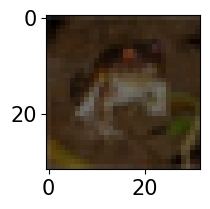

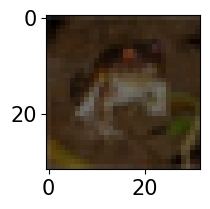

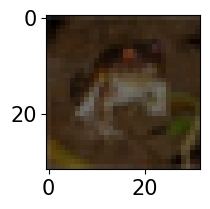

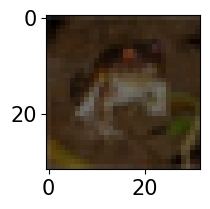

In [6]:
#Appendix: effect of lambda



dotheory=False
zeromean=False
m=0
s0s=np.power(10,np.linspace(-6,0,4))

dataNames=['MNIST','CIFAR']

P=1000
N=2*P

np.random.seed(0)
for dataName in dataNames:#dataNames:
    print(dataName)
    for s0 in s0s:
        seed=0
        X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed,zeromean=zeromean)  
        runTrial(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,m=0,dotheory=False,
                 s0=s0,sep=False,x_test=x_test,y_test=y_test,prepend='lamb_comp_',append='_seed'+str(seed))
#zeromean=False
#dataName='CIFAR'
#P=Ps[2]
#X,Y,x_train,x_test,y_train,y_test,train_ID,test_ID=loadData(dataName,N,P,seed=seed,zeromean=zeromean)  
#runTrial(dataName,N,P,seed,X,Y,x_train,y_train,train_ID,m=m,dotheory=dotheory,s0=s0)


In [40]:
Ps=np.ceil(np.power(10,np.linspace(1,3.4,6))).astype(int)

print(Ps*6)


[   60   186   552  1656  4992 15072]


In [52]:
Ps=np.power(2,np.linspace(4,11,6)).astype(int)
print(Ps)
print(Ps*5)


[  16   42  111  294  776 2048]
[   80   210   555  1470  3880 10240]


In [63]:
Ps=np.power(2,np.linspace(7.5,10,3)).astype(int)
print(Ps)
print(Ps*10)


[ 181  430 1024]
[ 1810  4300 10240]


In [4]:
Ps=np.ceil(np.power(10,np.linspace(2,4,6))).astype(int)



In [5]:
Ps

array([  100,   252,   631,  1585,  3982, 10000])